---
title: "Zerosum Monitoring Data Project"
format:
  html:
    code-fold: true
    self-contained: true
---

In [ ]:
#| echo: false

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA




# Data Collection and Methodology

## Data Collection Tools

This project utilized Kevin Huck's [Zerosum](https://github.com/UO-OACISS/zerosum/tree/main) tool for performance data collection. 

Zerosum efficiently captures system metrics by directly reading /proc files and interfacing with native performance collectors. Since these metrics are already maintained by the kernel, Zerosum introduces negligible overhead, ensuring that measurements accurately represent system behavior without distortion from the collection process itself.

The collected metrics encompass:

- Light Weight Process (LWP) statistics
- Hardware Thread (HWT) utilization metrics
- Memory allocation and throughput measurements
- GPU performance indicators
- Power consumption readings
- Temperature measurements

Data sampling occurred at regular 10-second intervals, providing consistent time-series observations throughout each workload execution.

## Experimental Setup

Data for this study was collected from two distinct computing environments:

### Thinkpad Workstation Setup

My personal Thinkpad workstation was used for generating controlled, labeled workload patterns. The relevant hardware specifications are summarized below:

| Component | Specification |
|-----------|---------------|
| Processor | 13th Gen Intel Core i7-1365U |
| Architecture | x86_64 |
| Physical Cores | 10 cores (Core(s) per socket) |
| Logical Processors | 12 CPUs (Thread(s) per core: 2) |
| CPU Max Frequency | 5.2 GHz |
| CPU Min Frequency | 400 MHz |
| L1 Cache | 352 KiB L1d (10 instances), 576 KiB L1i (10 instances) |
| L2 Cache | 6.5 MiB (4 instances) |
| L3 Cache | 12 MiB (1 instance) |
| NUMA Configuration | Single NUMA node |

I implemented five distinct multithreaded programs:

| Workload Type | Description | Configuration |
|---------------|-------------|---------------|
| CPU-bound     | Intensive prime number calculations | Max available cores |
| Memory-bound  | Allocated and manipulated 1000 MB of data | Max available cores |
| I/O-bound     | Sequential disk operations with 10MB chunk writes | Max available cores |
| Deadlocked    | Deliberate resource contention with mutex deadlocks | Max available cores |
| Unbalanced    | Randomized resource utilization spikes | Max available cores |

::: {.callout-info}
To minimize environmental variables, each program was executed in isolation with maximum available cores utilized. Background processes and system services were limited to the extent possible. Each workload type was run 10 times with consistent 100-second execution intervals.
:::

### Frontier Supercomputer Collection {#sec-frontier}

The [Frontier](https://www.olcf.ornl.gov/frontier/#1)  supercomputer provided real-world high-performance computing workload data.

On Frontier, Kevin executed XGC—a Multiphysics Magnetic Fusion Reactor Simulator designed to model plasma dynamics from the hot core to cold wall regions. This application was deployed across 64 compute nodes, utilizing all available CPU cores and GPU resources.

The Frontier dataset provided additional dimensions beyond those captured on the Thinkpad, including:
- Detailed GPU performance metrics
- RAPL (Running Average Power Limit) energy and power properties

These additional metrics presented valuable opportunities for unsupervised learning exploration.

## Dataset Limitations and Adjustments

### Initial Approach and Challenges

Initially, I planned to analyze monitoring data from four nodes available in the Zerosum repository. However, this approach proved insufficient for meaningful application state characterization and prediction.

Several limitations influenced the dataset design:
- Lack of light weight process (LWP) information (experimental setup focused on thread-level rather than process-level scheduling)
- Memory metrics aggregation across all HWTs and LWPs, complicating per-thread memory analysis

### Revised Observation Model {#sec-revised-model}

To address these constraints, I redesigned the observation model:
- Individual Hardware Threads (HWTs) became the primary analytical unit
- Each HWT was associated with its specific performance metrics
- Corresponding memory properties from the execution run were linked to each HWT
- LWP metrics were excluded from the final dataset

This was not an issue for the Frontier dataset. I used each LWP as an observation. No information was excluded from this dataset. 

## Feature Engineering Approach


The time-stepped nature of the performance data presented analytical challenges, particularly given the limited coverage of time-series analysis within the curriculum.

Rather than attempting to apply complex time-series methodologies, I implemented feature engineering techniques to transform temporal data into classification-compatible formats:

1. Initial approach: Each time step treated as an independent observation
   - Resulted in poor prediction performance (results not included in analysis)

2. Revised approach: Extracted features from each HWT in the laptop dataset
   - Mean values
   - Standard deviation
   - Rate-of-change metrics (delta terms between consecutive time steps)

These engineered features provided a more interpretable representation of the performance data while preserving the essential temporal patterns necessary for effective workload classification. Memory properties were associated with each HWT to maintain analytical coherence across the dataset.

In [188]:
#| echo: false

import pandas as pd
import glob
import os
import numpy as np
import re

file_path = "laptop_dataset"
data_dfs = []

# Check what files exist in the directory
# print(f"Directory exists: {os.path.exists(file_path)}")
# print(f"Directory contents: {os.listdir(file_path) if os.path.exists(file_path) else 'Directory not found'}")

# Try the glob pattern and see what it returns
example_data = glob.glob(f"{file_path}/*.csv")

# Only proceed if files were found
if example_data:
    for d, data_file in enumerate(example_data):
        try:
            df = pd.read_csv(data_file, delimiter=",")

            workload_type = os.path.splitext(os.path.basename(data_file))[0]
            workload_type = re.sub(r"\d+", "", workload_type)

            df["workload_type"] = workload_type

            run_id = f"{workload_type}_{d}"

            mask = df["name"] != "state"
            df.loc[mask, "value"] = pd.to_numeric(df.loc[mask, "value"], errors='coerce')
            # df["step"] = df.to_numeric(df["step"], errors='coerce')

            # Get only LWP data
            hwt_df = df[df["resource"] == "HWT"].copy()
            mem_df = df[df["resource"] == "Node"].copy()
            lwp_df = df[df["resource"] == "LWP"].copy()

            # Create a mask for rows where name is processor
            mask2 = lwp_df['name'] == "processor"

            # Get unique values from the value column where the mask is True
            processor_values = lwp_df.loc[mask2, 'value'].unique().tolist()
            # print(f"processors: {processor_values}")

            unique_lwp = lwp_df["index"].unique().tolist()
            # print(unique_lwp)

            # Group hwt by index
            hwt_dfs = [group for _, group in hwt_df.groupby('index')]
            # print(f"{example_data[d]} made {len(hwt_dfs)} groups")

            for df in hwt_dfs:
                hwt_mem_df = pd.concat([df, mem_df])
                hwt_mem_df["run_id"] = run_id
                data_dfs.append(hwt_mem_df)

            # print(f"Successfully read: {data_file}")
        except Exception as e:
            print(f"Error reading {data_file}: {e}")
else:
    print("No CSV files found in the specified directory.")

all_workload_types = []
for df in data_dfs:
    if 'workload_type' in df.columns:
        wts = df['workload_type'].unique().tolist()
        all_workload_types.extend(wts)

In [189]:
#| echo: false

agg_features = []
agg_data_dfs = data_dfs.copy()

for i, df in enumerate(agg_data_dfs):
    # Extract run_id for this dataframe
    run_id = df["run_id"].iloc[0] if "run_id" in df.columns and not df["run_id"].empty else f"unknown_{i}"
    
    # Calculate base metrics
    idle_times = sum(df[df["name"] == "idle_all"]["value"].tolist())
    user_times = sum(df[df["name"] == "user"]["value"].tolist())
    system_times = sum(df[df["name"] == "system"]["value"].tolist())
    iowait_times = sum(df[df["name"] == "iowait"]["value"].tolist()) if "iowait" in df["name"].values else 0
    total_time = idle_times + user_times + system_times + iowait_times
    
    # Get memory metrics if they exist
    mem_total = sum(df[df["name"] == "MemTotal kB"]["value"].astype(float).tolist()) if "MemTotal kB" in df["name"].values else 0
    mem_available = sum(df[df["name"] == "MemAvailable kB"]["value"].astype(float).tolist()) if "MemAvailable kB" in df["name"].values else 0
    mem_free = sum(df[df["name"] == "MemFree kB"]["value"].astype(float).tolist()) if "MemFree kB" in df["name"].values else 0

    # Common values for all new rows
    hostname = df["hostname"].iloc[0] if not df["hostname"].empty else None
    rank = df["rank"].iloc[0] if not df["rank"].empty else None
    shmrank = df["shmrank"].iloc[0] if not df["shmrank"].empty else None
    resource = "derived"
    type_val = "summary"
    index = i
    step = df["step"].iloc[0] if "step" in df.columns and not df["step"].empty else 0
    
    # Handle workload_type if it exists
    workload_type = df["workload_type"].iloc[0] if "workload_type" in df.columns and not df["workload_type"].empty else None

    # Get lists of values for calculating standard deviations
    idle_values = df[df["name"] == "idle_all"]["value"].tolist()
    user_values = df[df["name"] == "user"]["value"].tolist()
    system_values = df[df["name"] == "system"]["value"].tolist()
    iowait_values = df[df["name"] == "iowait"]["value"].tolist() if "iowait" in df["name"].values else []

    # Memory related values
    mem_total_values = df[df["name"] == "MemTotal kB"]["value"].astype(float).tolist() if "MemTotal kB" in df["name"].values else []
    mem_available_values = df[df["name"] == "MemAvailable kB"]["value"].astype(float).tolist() if "MemAvailable kB" in df["name"].values else []
    mem_free_values = df[df["name"] == "MemFree kB"]["value"].astype(float).tolist() if "MemFree kB" in df["name"].values else []
    
    # Calculate standard deviations (handle empty lists)
    idle_std = np.std(idle_values) if idle_values else 0
    user_std = np.std(user_values) if user_values else 0
    system_std = np.std(system_values) if system_values else 0
    iowait_std = np.std(iowait_values) if iowait_values else 0

    mem_total_std = np.std(mem_total_values) if mem_total_values else 0
    mem_available_std = np.std(mem_available_values) if mem_available_values else 0
    mem_free_std = np.std(mem_free_values) if mem_free_values else 0
    
    # Create new rows for derived metrics
    new_rows = [
        # CPU-Related Metrics
        {
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "user_time_percentage",
            "value": (user_times / total_time * 100) if total_time > 0 else 0,
            "workload_type": workload_type,
            "run_id": run_id
        },
        {
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "system_time_percentage",
            "value": (system_times / total_time * 100) if total_time > 0 else 0,
            "workload_type": workload_type,
            "run_id": run_id
        },
        {
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "idle_time_percentage",
            "value": (idle_times / total_time * 100) if total_time > 0 else 0,
            "workload_type": workload_type,
            "run_id": run_id
        },
        {
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "iowait_percentage",
            "value": (iowait_times / total_time * 100) if total_time > 0 else 0,
            "workload_type": workload_type,
            "run_id": run_id
        },
        # Memory-Related Metrics
        {
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "memory_utilization",
            "value": ((mem_total - mem_available) / mem_total * 100) if mem_total > 0 else 0,
            "workload_type": workload_type,
            "run_id": run_id
        },
        # Memory fragmentation (difference between free and available)
        {
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "memory_fragmentation",
            "value": ((mem_available - mem_free) / mem_total * 100) if mem_total > 0 else 0,
            "workload_type": workload_type,
            "run_id": run_id
        },
        # Active memory percentage
        {
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "active_memory_percentage",
            "value": ((mem_total - mem_free) / mem_total * 100) if mem_total > 0 else 0,
            "workload_type": workload_type,
            "run_id": run_id
        }
    ]

    # Add standard deviation metrics
    std_metrics = [
        # CPU metrics standard deviations
        {
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "user_time_std",
            "value": user_std,
            "workload_type": workload_type,
            "run_id": run_id
        },
        {
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "system_time_std",
            "value": system_std,
            "workload_type": workload_type,
            "run_id": run_id
        },
        {
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "idle_time_std",
            "value": idle_std,
            "workload_type": workload_type,
            "run_id": run_id
        },
        {
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "iowait_time_std",
            "value": iowait_std,
            "workload_type": workload_type,
            "run_id": run_id
        },
        
        # Memory metrics standard deviations
        {
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "mem_available_std",
            "value": mem_available_std,
            "workload_type": workload_type,
            "run_id": run_id
        },
        {
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "mem_free_std",
            "value": mem_free_std,
            "workload_type": workload_type,
            "run_id": run_id
        }
    ]

    # Add coefficient of variation (CV) metrics
    if np.mean(user_values) > 0:
        std_metrics.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "user_time_cv",
            "value": user_std / np.mean(user_values),
            "workload_type": workload_type,
            "run_id": run_id
        })

    if np.mean(system_values) > 0:
        std_metrics.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "system_time_cv",
            "value": system_std / np.mean(system_values),
            "workload_type": workload_type,
            "run_id": run_id
        })

    if np.mean(iowait_values) > 0:
        std_metrics.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "iowait_time_cv",
            "value": iowait_std / np.mean(iowait_values),
            "workload_type": workload_type,
            "run_id": run_id
        })

    if np.mean(mem_available_values) > 0:
        std_metrics.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "mem_available_cv",
            "value": mem_available_std / np.mean(mem_available_values),
            "workload_type": workload_type,
            "run_id": run_id
        })
    
    # Calculate delta features (for metrics that have sequences)
    delta_metrics = []
    
    # Only calculate deltas if we have enough sequential samples
    if len(user_values) > 1:
        # Sort values by sequence order
        sorted_indices = np.argsort(df[df["name"] == "user"]["index"].values)
        sorted_user_values = np.array(user_values)[sorted_indices]
        sorted_system_values = np.array(system_values)[sorted_indices]
        
        if "iowait" in df["name"].values:
            sorted_iowait_values = np.array(iowait_values)[sorted_indices]
        else:
            sorted_iowait_values = []
            
        if len(mem_available_values) > 1:
            mem_indices = np.argsort(df[df["name"] == "MemAvailable kB"]["index"].values)
            sorted_mem_available = np.array(mem_available_values)[mem_indices]
        else:
            sorted_mem_available = []
            
        # Calculate the average delta (rate of change)
        if len(sorted_user_values) > 1:
            user_deltas = np.diff(sorted_user_values)
            avg_user_delta = np.mean(user_deltas)
            user_delta_std = np.std(user_deltas)
            
            delta_metrics.append({
                "hostname": hostname,
                "rank": rank,
                "shmrank": shmrank,
                "step": step,
                "resource": resource,
                "type": type_val,
                "index": index,
                "name": "user_time_delta_avg",
                "value": avg_user_delta,
                "workload_type": workload_type,
                "run_id": run_id
            })
            
            delta_metrics.append({
                "hostname": hostname,
                "rank": rank,
                "shmrank": shmrank,
                "step": step,
                "resource": resource,
                "type": type_val,
                "index": index,
                "name": "user_time_delta_std",
                "value": user_delta_std,
                "workload_type": workload_type,
                "run_id": run_id
            })
        
        if len(sorted_system_values) > 1:
            system_deltas = np.diff(sorted_system_values)
            avg_system_delta = np.mean(system_deltas)
            system_delta_std = np.std(system_deltas)
            
            delta_metrics.append({
                "hostname": hostname,
                "rank": rank,
                "shmrank": shmrank,
                "step": step,
                "resource": resource,
                "type": type_val,
                "index": index,
                "name": "system_time_delta_avg",
                "value": avg_system_delta,
                "workload_type": workload_type,
                "run_id": run_id
            })
            
            delta_metrics.append({
                "hostname": hostname,
                "rank": rank,
                "shmrank": shmrank,
                "step": step,
                "resource": resource,
                "type": type_val,
                "index": index,
                "name": "system_time_delta_std",
                "value": system_delta_std,
                "workload_type": workload_type,
                "run_id": run_id
            })
        
        if len(sorted_iowait_values) > 1:
            iowait_deltas = np.diff(sorted_iowait_values)
            avg_iowait_delta = np.mean(iowait_deltas)
            iowait_delta_std = np.std(iowait_deltas)
            
            delta_metrics.append({
                "hostname": hostname,
                "rank": rank,
                "shmrank": shmrank,
                "step": step,
                "resource": resource,
                "type": type_val,
                "index": index,
                "name": "iowait_time_delta_avg",
                "value": avg_iowait_delta,
                "workload_type": workload_type,
                "run_id": run_id
            })
            
            delta_metrics.append({
                "hostname": hostname,
                "rank": rank,
                "shmrank": shmrank,
                "step": step,
                "resource": resource,
                "type": type_val,
                "index": index,
                "name": "iowait_time_delta_std",
                "value": iowait_delta_std,
                "workload_type": workload_type,
                "run_id": run_id
            })
        
        if len(sorted_mem_available) > 1:
            mem_deltas = np.diff(sorted_mem_available)
            avg_mem_delta = np.mean(mem_deltas)
            mem_delta_std = np.std(mem_deltas)
            
            delta_metrics.append({
                "hostname": hostname,
                "rank": rank,
                "shmrank": shmrank,
                "step": step,
                "resource": resource,
                "type": type_val,
                "index": index,
                "name": "mem_available_delta_avg",
                "value": avg_mem_delta,
                "workload_type": workload_type,
                "run_id": run_id
            })
            
            delta_metrics.append({
                "hostname": hostname,
                "rank": rank,
                "shmrank": shmrank,
                "step": step,
                "resource": resource,
                "type": type_val,
                "index": index,
                "name": "mem_available_delta_std",
                "value": mem_delta_std,
                "workload_type": workload_type,
                "run_id": run_id
            })

    # Combine all metrics
    agg_features.extend(new_rows)
    agg_features.extend(std_metrics)
    agg_features.extend(delta_metrics)

In [190]:
#| echo: false
agg_features_df = pd.DataFrame(agg_features)
stats_by_metric = {}
metric_names = agg_features_df['name'].unique().tolist()

for metric in metric_names:
    metric_df = agg_features_df[agg_features_df['name'] == metric]
    
    stats = {
        'count': len(metric_df),
        'mean': metric_df['value'].mean(),
        'median': metric_df['value'].median(),
        'std': metric_df['value'].std(),
        'min': metric_df['value'].min(),
        'max': metric_df['value'].max(),
        '25%': metric_df['value'].quantile(0.25),
        '75%': metric_df['value'].quantile(0.75)
    }
    
    stats_by_metric[metric] = pd.DataFrame([stats])

stats_by_run = {}
run_ids = agg_features_df['run_id'].unique()

for run_id in run_ids:
    run_df = agg_features_df[agg_features_df['run_id'] == run_id]
    
    pivot_df = run_df.pivot_table(
        index=['run_id'],
        columns='name',
        values='value',
        aggfunc='mean'
    )
    
    stats_by_run[run_id] = pivot_df

In [191]:
#| echo: false
# Create summary statistics by workload type
workload_stats = {}
workload_types = agg_features_df['workload_type'].unique()

for workload in workload_types:
    # Filter data for this workload
    workload_df = agg_features_df[agg_features_df['workload_type'] == workload]
    
    # Create pivot table with metrics as columns
    pivot_df = workload_df.pivot_table(
        index=['workload_type'],
        columns='name',
        values='value',
        aggfunc=['mean', 'std', 'min', 'max', 'median']
    )
    
    workload_stats[workload] = pivot_df

# # Print summary for each workload
# for workload, stats in workload_stats.items():
#     # print(f"\nWorkload Type: {workload}")
#     # print("-" * 40)
    
#     # Get means and standard deviations
#     means = stats['mean']
#     stds = stats['std']
    
#     # Print key metrics
#     for metric in means.columns:
#         mean_val = means[metric].iloc[0]
#         std_val = stds[metric].iloc[0]
#         # print(f"{metric}: {mean_val:.2f} ± {std_val:.2f}")

### What are the distinguishing statistical properties (means, variances, distributions) of system metrics across different workload types?

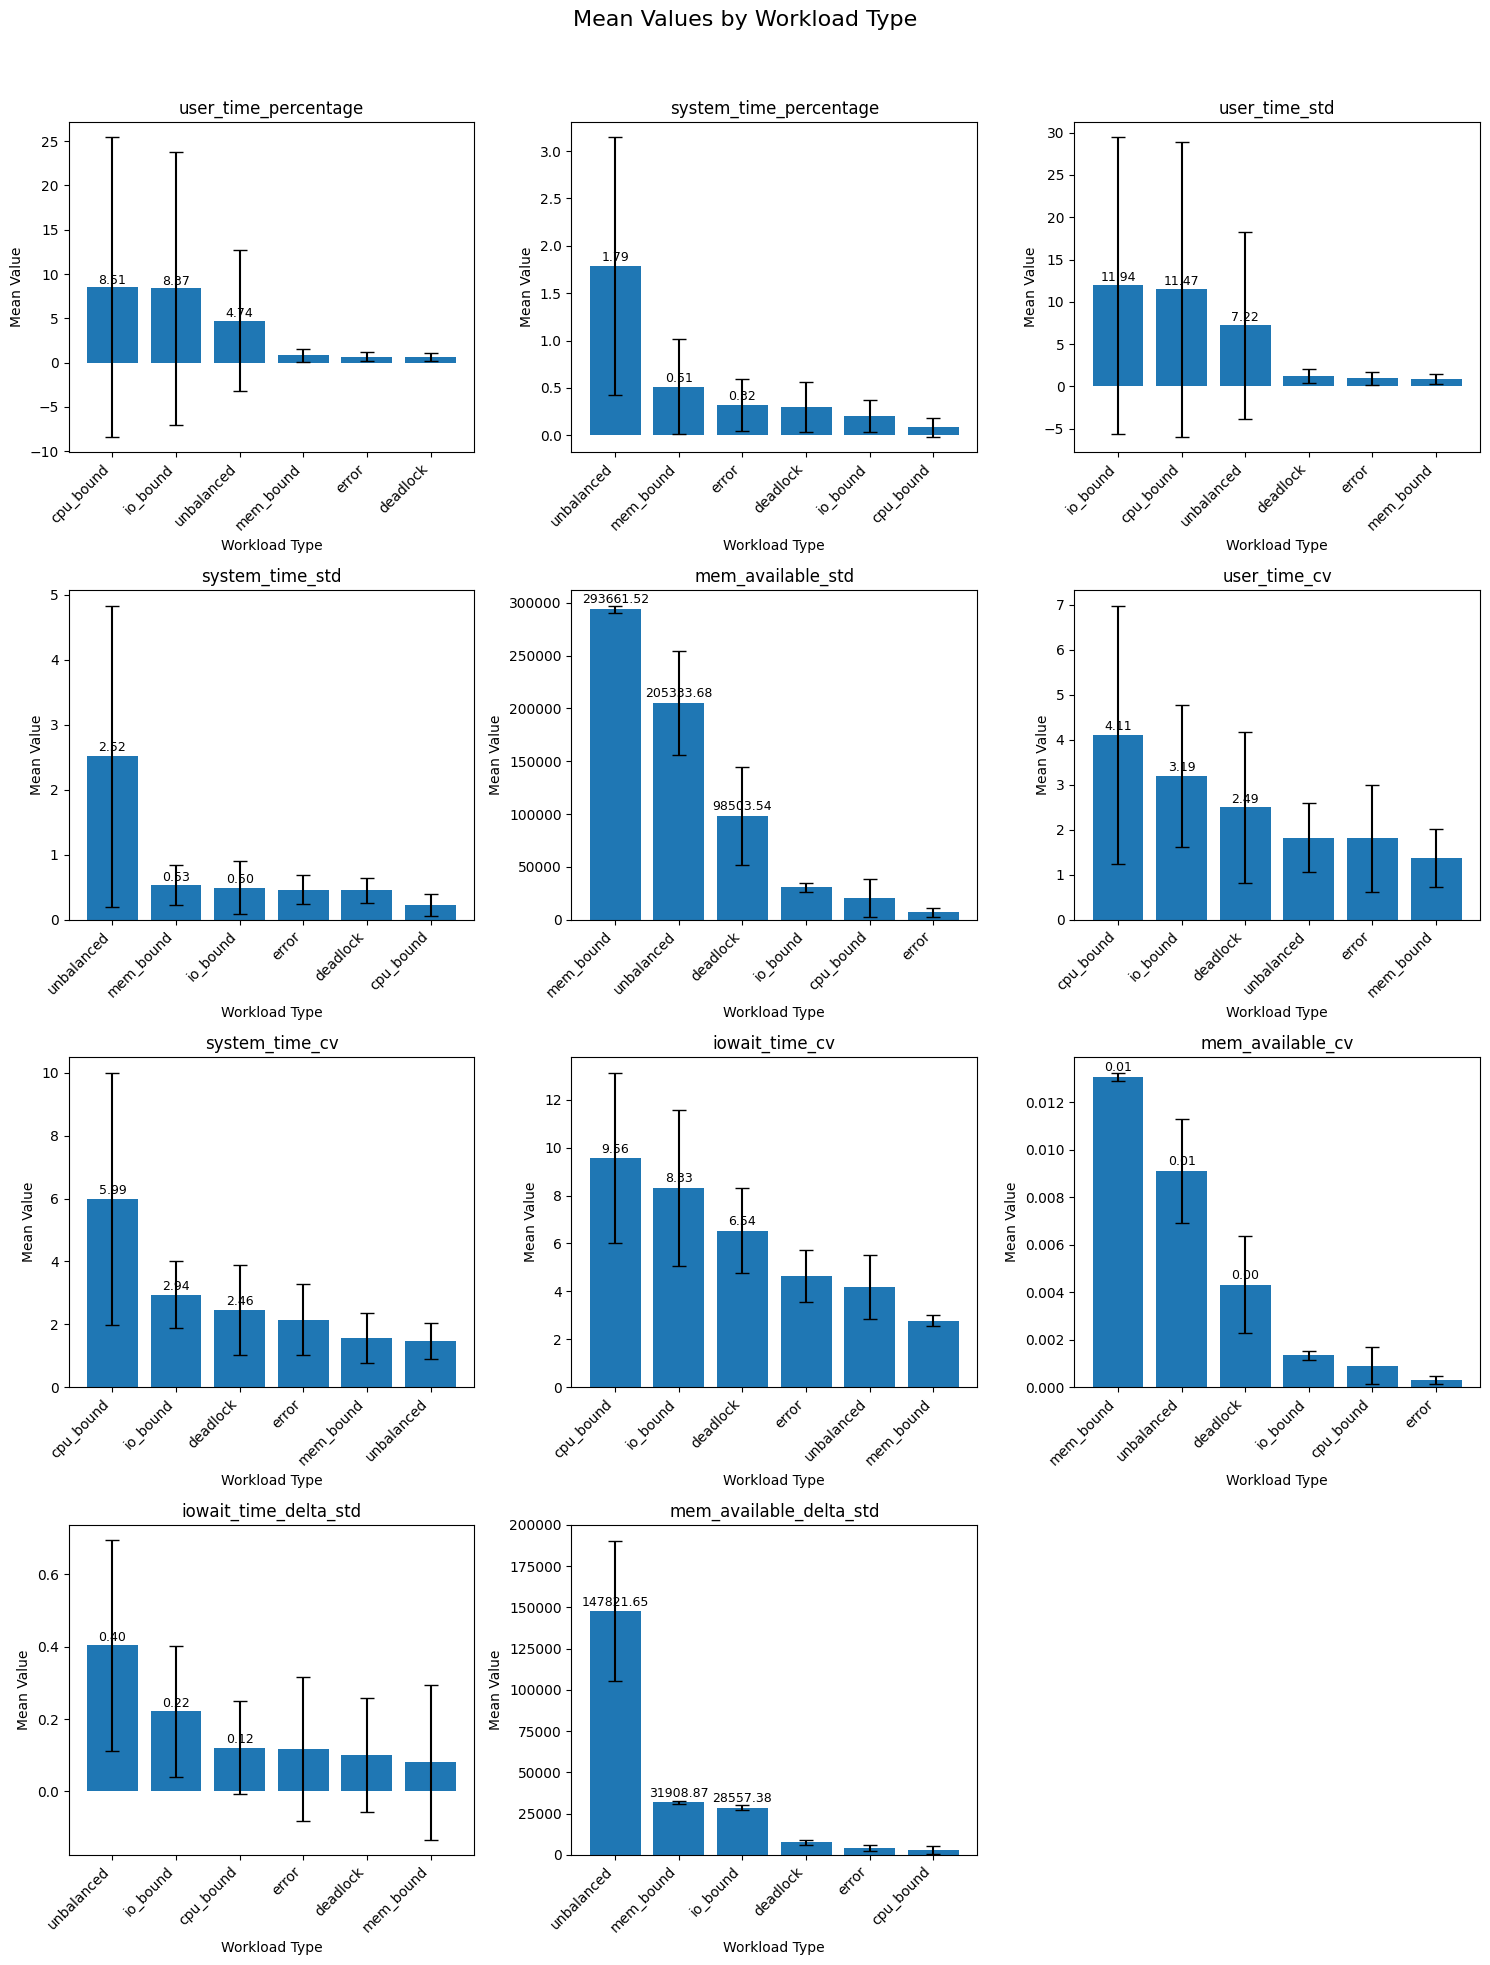

In [192]:
#| echo: false

# Create a figure for each metric
figs = {}
# Create a combined figure with all metrics
interesting_metrics = ['user_time_percentage', 'system_time_percentage', 'user_time_std', 'system_time_std', 
                       'mem_available_std', 'user_time_cv', 'system_time_cv', 'iowait_time_cv', 
                       'mem_available_cv', 'iowait_time_delta_std', 'mem_available_delta_std']
if interesting_metrics:
    # Calculate grid dimensions
    n_plots = len(interesting_metrics)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle('Mean Values by Workload Type', fontsize=16)
    
    # Make axes iterable if there's only one row or column
    if n_plots == 1:
        axes = np.array([axes])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Plot each metric
    for i, metric in enumerate(interesting_metrics):
        row = i // n_cols
        col = i % n_cols
        
        metric_df = agg_features_df[agg_features_df['name'] == metric]
        
        if not metric_df.empty:
            ax = axes[row, col]
            
            # Calculate summary statistics
            summary = metric_df.groupby('workload_type')['value'].agg(['mean', 'std'])
            summary = summary.sort_values('mean', ascending=False)
            
            # Create bar chart
            bars = ax.bar(summary.index, summary['mean'], yerr=summary['std'], capsize=5)
            
            # Add value labels on top 3 bars to avoid cluttering
            for j, bar in enumerate(bars):
                if j < 3:  # Only label top 3 bars
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01 * max(summary['mean']),
                            f'{height:.2f}', ha='center', va='bottom', fontsize=9)
            
            ax.set_title(metric)
            ax.set_xlabel('Workload Type')
            ax.set_ylabel('Mean Value')
            
            # Rotate x-tick labels
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Hide any unused subplots
    for i in range(n_plots, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave room for suptitle
    figs['combined'] = fig
    

To validate and visualize the discriminative ability of the derived features, I averaged each metric across workload categories, creating comparative bar graphs. These visualizations effectively demonstrate how the derived metrics capture fundamental differences between workload types. The bar graphs shown were ones I thought were most interesting and were the most different between workloads. 

### What configurations lead to high runtime variability or inefficient resource mapping?
### What statistical methods can be used for quick descriptive analysis?

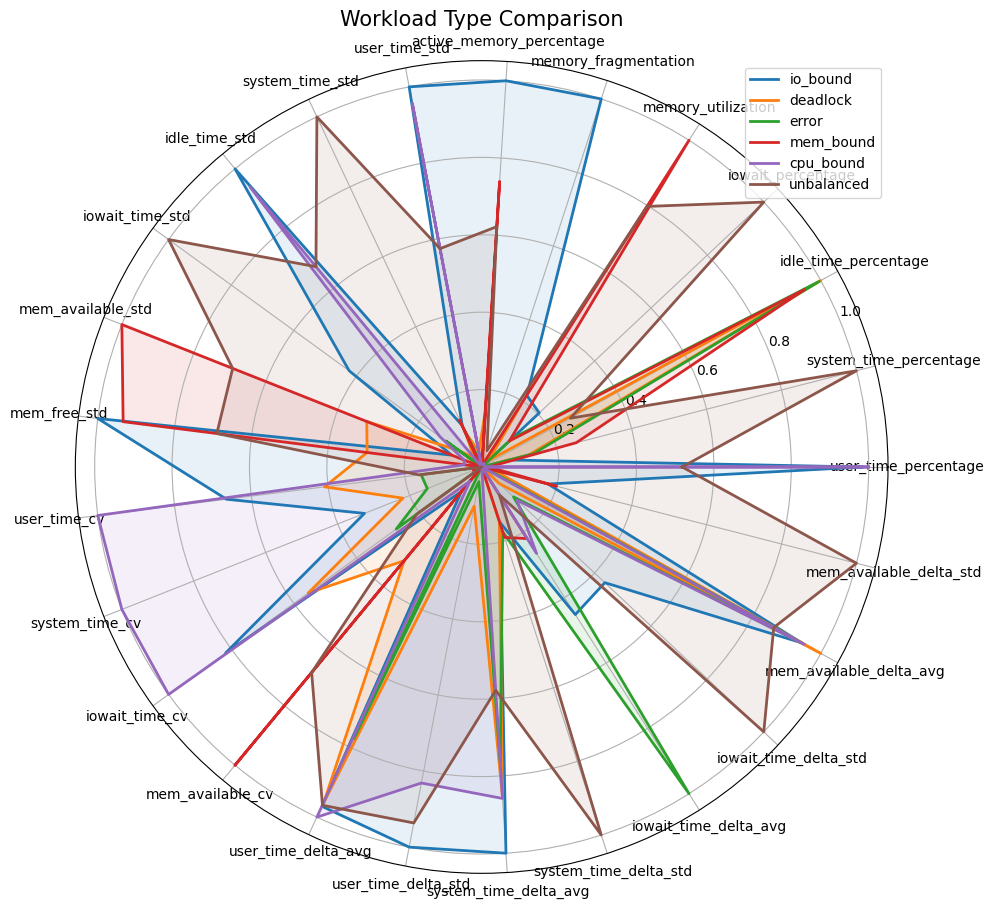

In [193]:

#Calculate mean for each metric and workload
summary_data = {}
workload_types = agg_features_df['workload_type'].unique()

for workload in workload_types:
    summary_data[workload] = {}
    for metric in metric_names:
        metric_data = agg_features_df[(agg_features_df['workload_type'] == workload) & 
                                    (agg_features_df['name'] == metric)]
        if not metric_data.empty:
            summary_data[workload][metric] = metric_data['value'].mean()

# Normalize values to 0-1 scale for comparison
for metric in metric_names:
    all_values = [data.get(metric, 0) for data in summary_data.values()]
    min_val = min(all_values)
    max_val = max(all_values)
    
    if max_val > min_val:
        for workload in workload_types:
            if metric in summary_data[workload]:
                summary_data[workload][metric] = (summary_data[workload][metric] - min_val) / (max_val - min_val)

# Create radar chart
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

# Set the angles for each metric
angles = np.linspace(0, 2*np.pi, len(metric_names), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Plot each workload
for i, workload in enumerate(workload_types):
    values = [summary_data[workload].get(metric, 0) for metric in metric_names]
    values += values[:1]  # Close the loop
    
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=workload)
    ax.fill(angles, values, alpha=0.1)

# Set labels and title
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metric_names)
ax.set_title('Workload Type Comparison', fontsize=15, pad=25)
ax.legend(loc='upper right')

plt.tight_layout()

An analysis of the spider plot reveals distinct workload characteristics across various metrics. The visualization effectively delineates expected patterns in resource utilization profiles. For example, unbalanced workloads demonstrate significant temporal variation, manifested through elevated standard deviations and pronounced differentials between consecutive time intervals, as we would expect. 

CPU-bound workloads exhibit high coefficients of variation, correlating with the substantial peaks observed in user_time percentage measurements. This variance is unexpected as it indicates potential inefficiencies in execution patterns. The elevated coefficient of variance values across multiple dimensions suggest underlying systemic issues affecting computational consistency, which was not the intention when executing this workload. 

Given that the workload consists exclusively of homogeneous prime number calculations across all threads, the observed variability is unlikely attributable to non-uniform task distribution. Rather, the data more strongly supports resource contention as the primary causal factor. The competition among identical computational processes for shared system resources presents the most probable explanation for the performance irregularities documented in the metrics.

### Can we predict workload types using Zerosum data?

In [ ]:
research

label_encoder = LabelEncoder()
y_data_encoded = label_encoder.fit_transform(y)

Index(['hostname', 'rank', 'shmrank', 'step', 'resource', 'type', 'index',
       'name', 'value', 'workload_type', 'run_id'],
      dtype='object')
Feature matrix shape: (720, 22)
Feature columns: Index(['active_memory_percentage', 'idle_time_percentage', 'idle_time_std',
       'iowait_percentage', 'iowait_time_delta_avg', 'iowait_time_delta_std',
       'iowait_time_std', 'mem_available_cv', 'mem_available_delta_avg',
       'mem_available_delta_std', 'mem_available_std', 'mem_free_std',
       'memory_fragmentation', 'memory_utilization', 'system_time_delta_avg',
       'system_time_delta_std', 'system_time_percentage', 'system_time_std',
       'user_time_delta_avg', 'user_time_delta_std', 'user_time_percentage',
       'user_time_std'],
      dtype='object', name='name')

Label distribution:
workload_type
io_bound      120
deadlock      120
error         120
mem_bound     120
cpu_bound     120
unbalanced    120
Name: count, dtype: int64


### Which events or metrics are correlated, and how do these relationships affect system performance? 

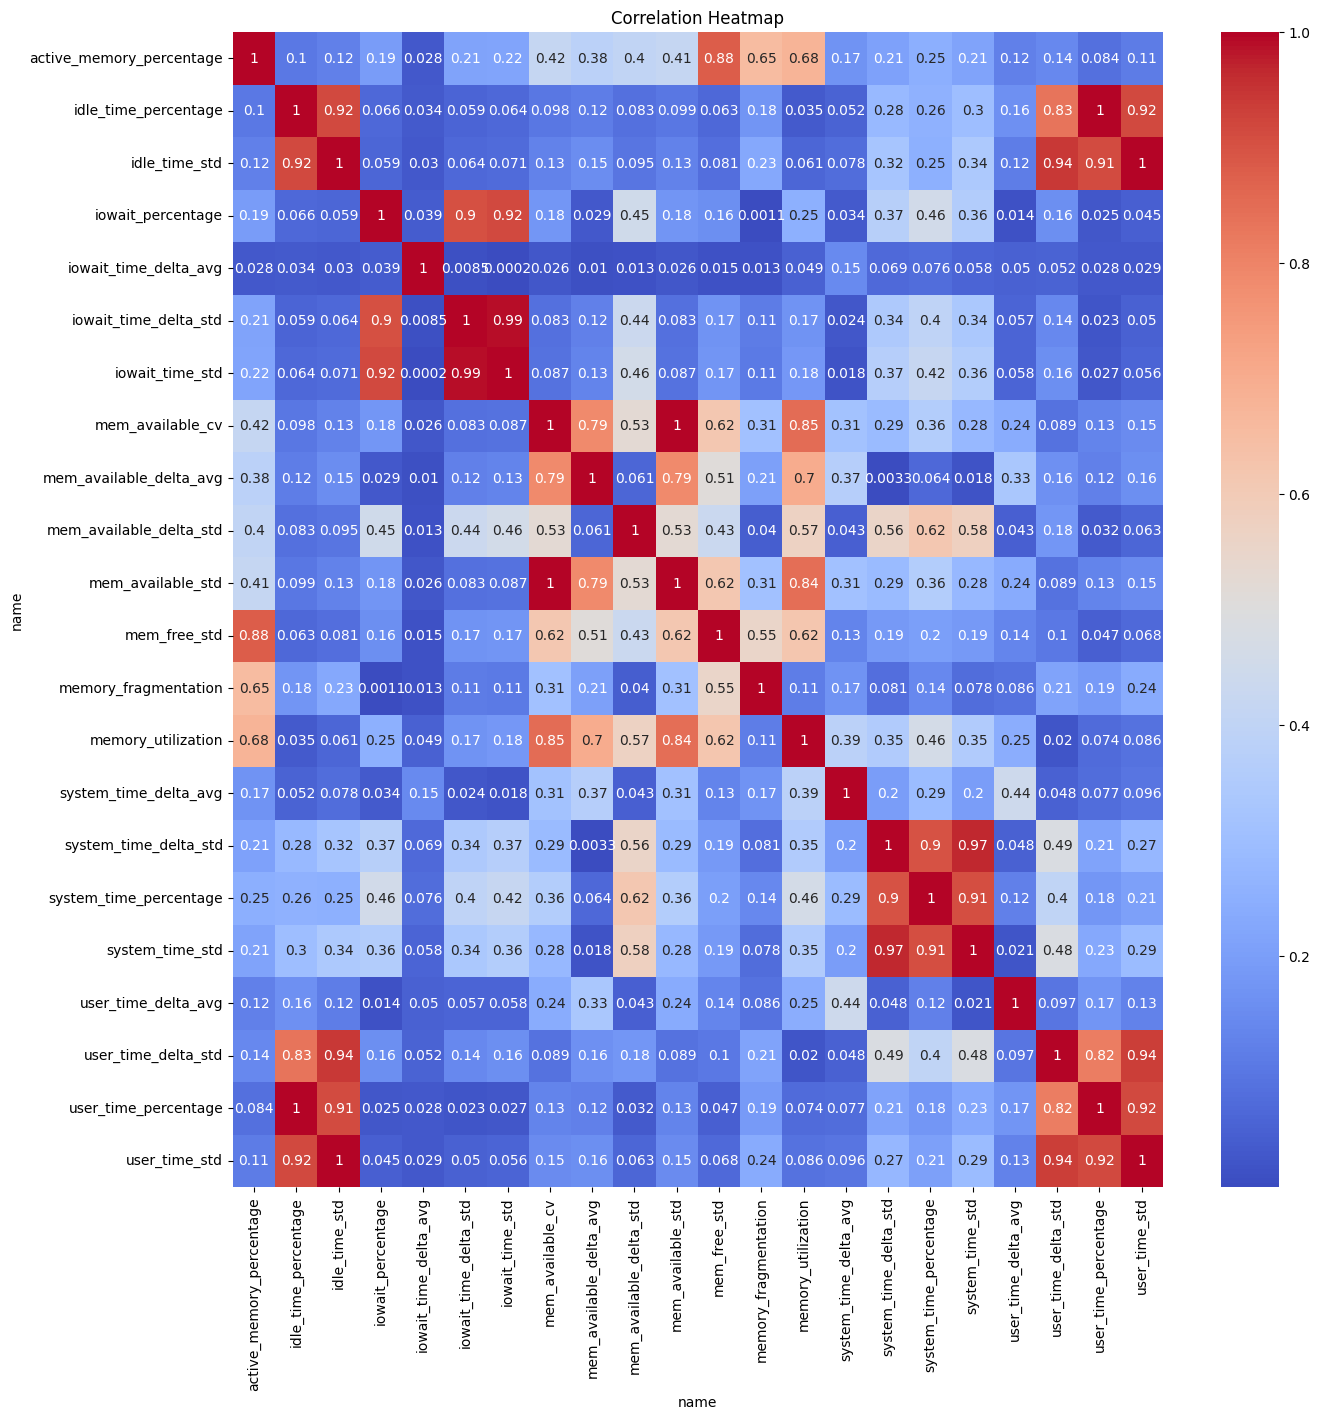

In [195]:
#| echo:false
threshold = .8

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
# print(f"Dropping {len(to_drop)} correlated features: {', '.join(to_drop)}")
plt.figure(figsize=(15,15))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
    
# Show the pairs that led to dropping
high_corr_pairs = []
for col in to_drop:
    correlated_with = list(upper.index[upper[col] > threshold])
    for other_col in correlated_with:
        pair_corr = corr_matrix.loc[col, other_col]
        high_corr_pairs.append((col, other_col, pair_corr))
    # Display the highly correlated pairs
    # for col1, col2, corr in high_corr_pairs:
    #     print(f"Correlation between {col1} and {col2}: {corr:.4f}")
    

User time, system time, and idle times are highly correlated. It is not immediately evident how these correlations relate to system health or workload type. 

#### Logistic Regression

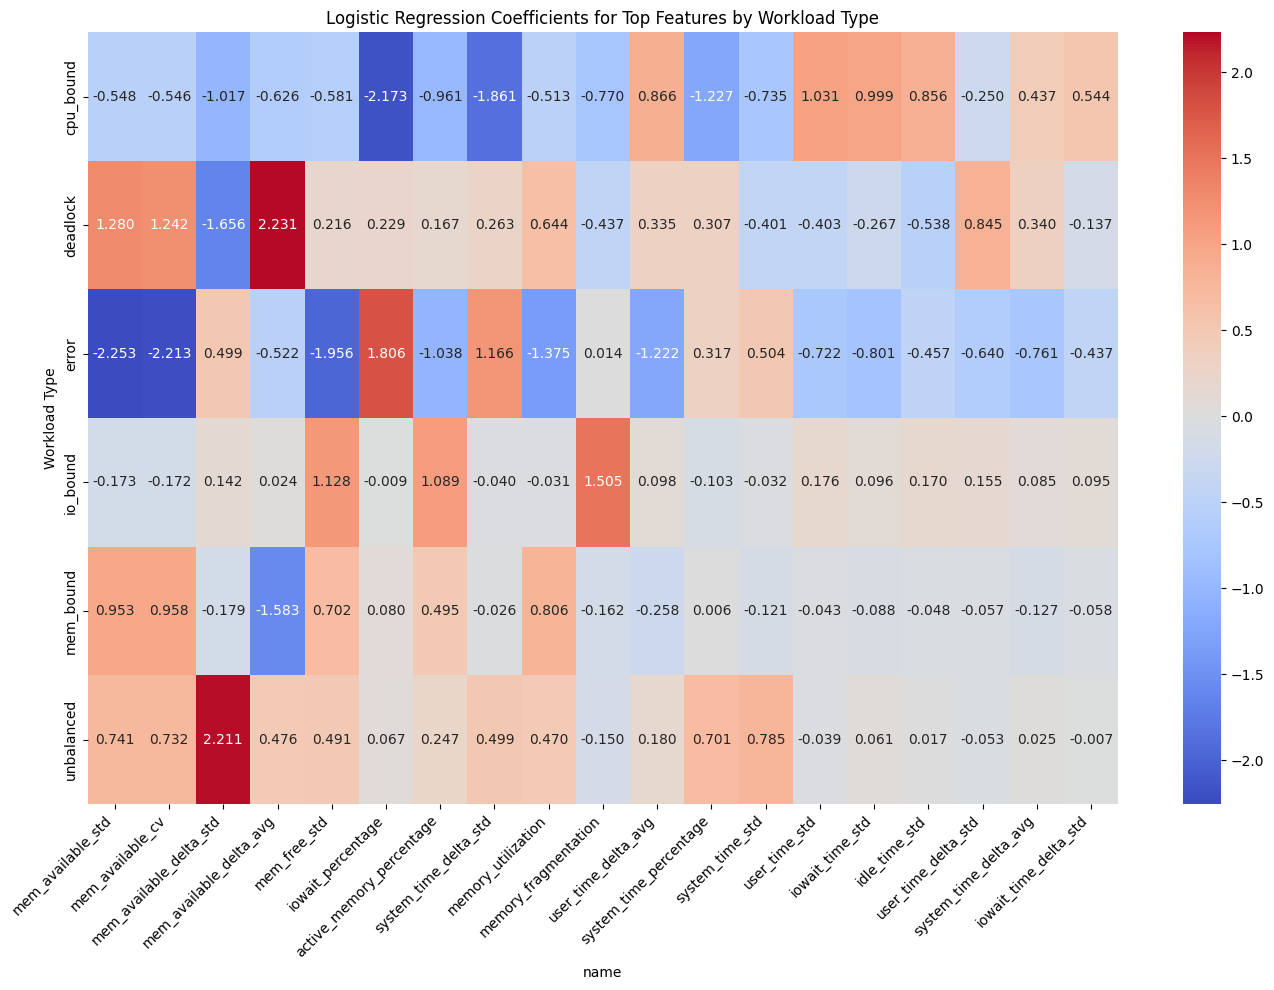

In [196]:
# Use k fold cv
group_kfold = GroupKFold(n_splits=5)

random_state = 42
max_iter = 1000

model = LogisticRegression(
    random_state=random_state,
    max_iter=max_iter,
    solver='lbfgs',
    C=1.0
)

cv_scores = cross_val_score(
    model, X_normalized, y, groups=groups, 
    cv=group_kfold, scoring='accuracy'
)

# print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
# print(f"Individual fold scores: {cv_scores}")

# Feature analysis
model.fit(X_normalized, y)

feature_importance = pd.DataFrame(
    model.coef_, 
    columns=X.columns,
    index=model.classes_
)

plt.figure(figsize=(14, 10))

abs_importance = feature_importance.abs()

num_of_features = 19

top_features_overall = abs_importance.mean().sort_values(ascending=False).head(num_of_features).index

sns.heatmap(
    feature_importance[top_features_overall],
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".3f"
)
plt.title('Logistic Regression Coefficients for Top Features by Workload Type')
plt.ylabel('Workload Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Test Accuracy on held-out runs: 0.9375

Classification Report:
              precision    recall  f1-score   support

   cpu_bound       0.80      0.83      0.82        24
    deadlock       1.00      1.00      1.00        24
       error       0.83      0.79      0.81        24
    io_bound       1.00      1.00      1.00        24
   mem_bound       1.00      1.00      1.00        24
  unbalanced       1.00      1.00      1.00        24

    accuracy                           0.94       144
   macro avg       0.94      0.94      0.94       144
weighted avg       0.94      0.94      0.94       144



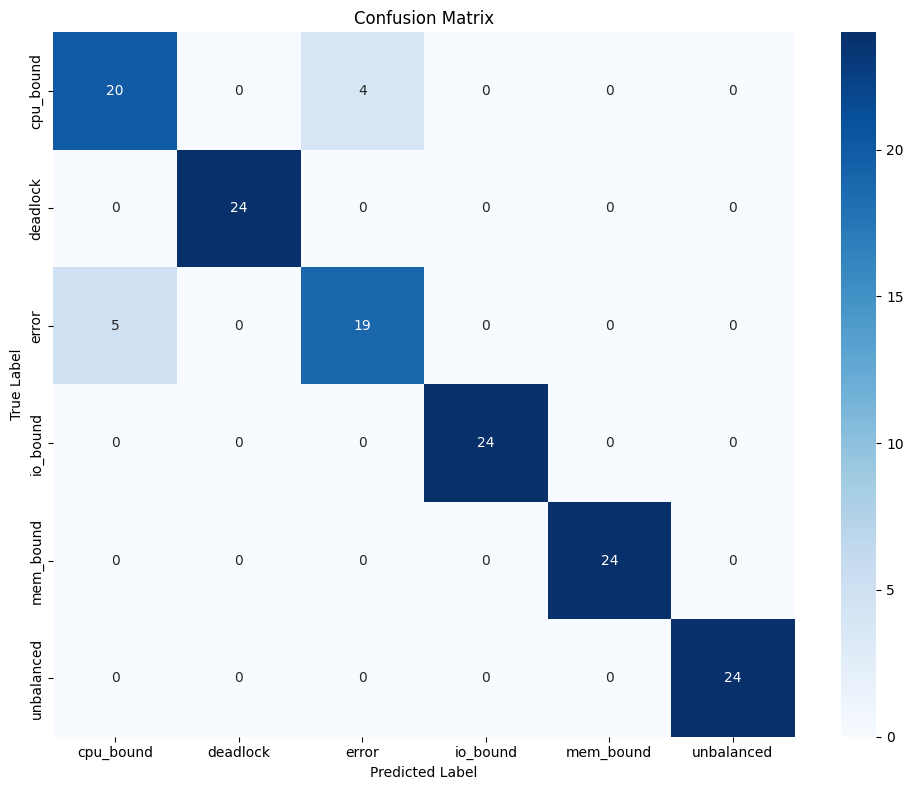

Average prediction confidence: 0.9107


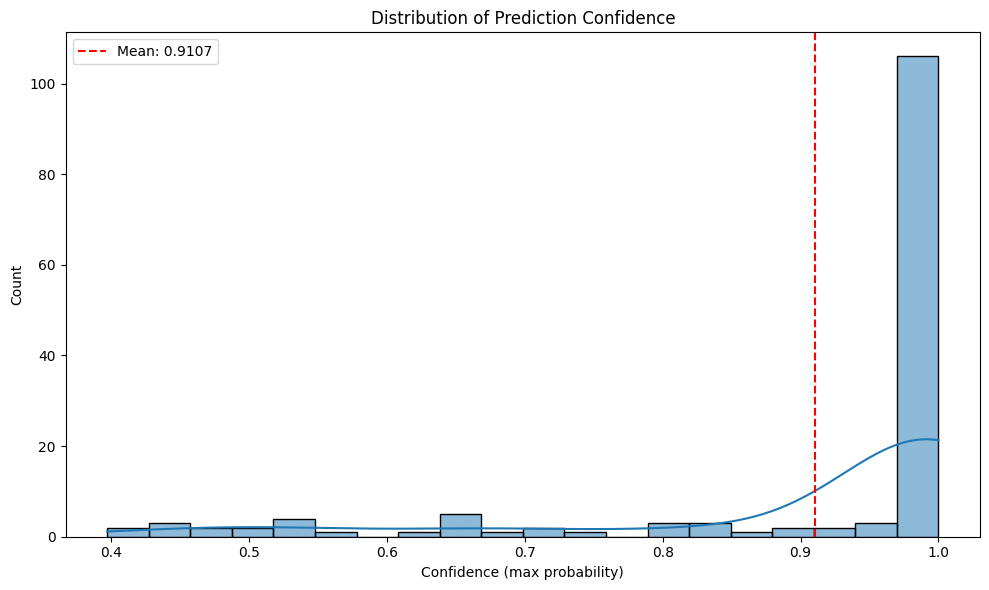

In [197]:
unique_groups = pivot_df['run_id'].unique()
    
workload_types = [group.split('_')[0] for group in unique_groups]

# Dictionary to track run IDs per workload type
workload_to_runs = {}
for run, wl in zip(unique_groups, workload_types):
    if wl not in workload_to_runs:
        workload_to_runs[wl] = []
    workload_to_runs[wl].append(run)

# Create train/test split at the run level
train_runs = []
test_runs = []

for wl, runs in workload_to_runs.items():
    n_test = max(1, int(len(runs) * 0.2))
    
    np.random.seed(random_state)
    np.random.shuffle(runs)
    
    test_runs.extend(runs[:n_test])
    train_runs.extend(runs[n_test:])

# Create masks for the data
train_mask = pivot_df['run_id'].isin(train_runs)
test_mask = pivot_df['run_id'].isin(test_runs)

# Split data
X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy on held-out runs: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=model.classes_,
    yticklabels=model.classes_
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

y_proba = model.predict_proba(X_test_scaled)

confidence = np.max(y_proba, axis=1)
mean_confidence = np.mean(confidence)

print(f"Average prediction confidence: {mean_confidence:.4f}")

plt.figure(figsize=(10, 6))
sns.histplot(confidence, bins=20, kde=True)
plt.axvline(mean_confidence, color='r', linestyle='--', label=f'Mean: {mean_confidence:.4f}')
plt.title('Distribution of Prediction Confidence')
plt.xlabel('Confidence (max probability)')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

In [198]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

# First, make sure you have the test_run_ids properly extracted
# The right way to get the run_ids for test samples:
test_run_ids = pivot_df.loc[test_mask, 'run_id'].values

# Make sure your y_test, X_test, etc. are numpy arrays before proceeding
if hasattr(X_test, 'values'):
    X_test_np = X_test.values
else:
    X_test_np = np.array(X_test)

if hasattr(y_test, 'values'):
    y_test_np = y_test.values
else:
    y_test_np = np.array(y_test)

if hasattr(X_test_scaled, 'values'):
    X_test_scaled_np = X_test_scaled.values
else:
    X_test_scaled_np = np.array(X_test_scaled)

# Generate predictions if you haven't already
y_test_pred = model.predict(X_test_scaled_np)

from sklearn.utils import resample

def bootstrap_confidence_interval(y_true, y_pred, groups):
    unique_groups = np.unique(groups)
    accuracies = []
    
    for _ in range(1000):
        # Sample groups with replacement
        sampled_groups = np.random.choice(unique_groups, size=len(unique_groups), replace=True)
        
        # Get all samples from sampled groups
        indices = np.concatenate([np.where(groups == group)[0] for group in sampled_groups])
        
        if len(indices) > 0:
            y_true_boot = y_true[indices]
            y_pred_boot = y_pred[indices]
            acc = accuracy_score(y_true_boot, y_pred_boot)
            accuracies.append(acc)
    
    # Calculate confidence interval
    lower = np.percentile(accuracies, .05/2 * 100)
    upper = np.percentile(accuracies, (1 - .05/2) * 100)
    
    return np.mean(accuracies), lower, upper

# 2. Bootstrap confidence intervals
mean_acc, ci_lower, ci_upper = bootstrap_confidence_interval(
    y_test_np, y_test_pred, test_run_ids
)

print(f"\nBootstrap 95% Confidence Interval for Accuracy:")
print(f"{mean_acc:.4f} ({ci_lower:.4f}, {ci_upper:.4f})")

# 4. Analysis of performance by workload type
# Group test set predictions by workload type
workload_performance = {}
for wl in np.unique([group.split('_')[0] for group in test_run_ids]):
    # Create mask for this workload in test set
    wl_mask = np.array([run_id.split('_')[0] == wl for run_id in test_run_ids])
    
    if np.any(wl_mask):
        # Get predictions and true labels for this workload
        wl_y_true = y_test_np[wl_mask]
        wl_y_pred = y_test_pred[wl_mask]
        
        # Calculate accuracy
        wl_acc = accuracy_score(wl_y_true, wl_y_pred)
        workload_performance[wl] = {
            'accuracy': wl_acc,
            'n_samples': np.sum(wl_mask)
        }

# Check the data type of your y_train
print(f"y_train data type: {type(y_train)}")
if hasattr(y_train, 'dtype'):
    print(f"y_train dtype: {y_train.dtype}")

# Print a sample of unique values
print("Sample of unique values in y_train:")
if hasattr(y_train, 'unique'):
    print(y_train.unique()[:10])  # First 10 unique values
else:
    unique_vals = np.unique(y_train)
    print(unique_vals[:10])  # First 10 unique values

# Convert labels to integers for bincount
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Now use the encoded values for bincount
y_train_counts = np.bincount(y_train_encoded)
majority_class = np.argmax(y_train_counts)
baseline_acc = y_train_counts[majority_class] / len(y_train_encoded)

print(f"\nClass distribution:")
for i, count in enumerate(y_train_counts):
    original_label = label_encoder.inverse_transform([i])[0]
    print(f"  {original_label}: {count} samples ({count/len(y_train_encoded):.2%})")

print(f"\nBaseline accuracy (majority class): {baseline_acc:.4f}")

# Use the encoded labels for the binomial test
y_test_pred_encoded = label_encoder.transform(y_test_pred)
test_acc = accuracy_score(y_test_encoded, y_test_pred_encoded)
n_correct = int(test_acc * len(y_test_encoded))
p_value_baseline = stats.binomtest(n_correct, len(y_test_encoded), baseline_acc, alternative='greater')

print(f"Model accuracy: {test_acc}")
print(f"Binomial test p-value: {p_value_baseline}")


Bootstrap 95% Confidence Interval for Accuracy:
0.9385 (0.8681, 1.0000)
y_train data type: <class 'pandas.core.series.Series'>
y_train dtype: object
Sample of unique values in y_train:
['io_bound' 'deadlock' 'error' 'mem_bound' 'cpu_bound' 'unbalanced']

Class distribution:
  cpu_bound: 96 samples (16.67%)
  deadlock: 96 samples (16.67%)
  error: 96 samples (16.67%)
  io_bound: 96 samples (16.67%)
  mem_bound: 96 samples (16.67%)
  unbalanced: 96 samples (16.67%)

Baseline accuracy (majority class): 0.1667
Model accuracy: 0.9375
Binomial test p-value: BinomTestResult(k=135, n=144, alternative='greater', statistic=0.9375, pvalue=9.94149207413902e-93)


#### Did the shared memory feature make things too easy to classify? 

In [199]:
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd


def interpret_cramers_v(v):
    if v < 0.1:
        return "Negligible association"
    elif v < 0.2:
        return "Weak association"
    elif v < 0.3:
        return "Moderate association"
    else:
        return "Strong association"
    
# Create a contingency table (confusion matrix)
contingency_table = pd.crosstab(y_test_encoded, 
                               y_test_pred_encoded,
                               rownames=['Actual'],
                               colnames=['Predicted'])

print("Contingency Table (Confusion Matrix):")
print(contingency_table)

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Square Test Results:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.8f}")
print(f"Degrees of freedom: {dof}")
print(f"Result: {'Significant association' if p_value < 0.05 else 'No significant association'} between actual and predicted classes")



Contingency Table (Confusion Matrix):
Predicted   0   1   2   3   4   5
Actual                           
0          20   0   4   0   0   0
1           0  24   0   0   0   0
2           5   0  19   0   0   0
3           0   0   0  24   0   0
4           0   0   0   0  24   0
5           0   0   0   0   0  24

Chi-Square Test Results:
Chi-square statistic: 632.3478
p-value: 0.00000000
Degrees of freedom: 25
Result: Significant association between actual and predicted classes


#### Maybe not! p-value is very low. Therefore, there is some statistical significance and it is unlikely my model is predicting well due to chance. 

### What is the minimum set of performance metrics needed to accurately classify workload types with high accuracy?

In [200]:
# Create a new dataset with only the top 10 features
X_top10 = X[top_features_overall]

X_top10_normalized = scaler.fit_transform(X_top10)

# For training and testing, use the same splits but with reduced features
X_train_top10 = X_train[top_features_overall]
X_test_top10 = X_test[top_features_overall]

# Scale the reduced feature set
X_train_top10_scaled = scaler.fit_transform(X_train_top10)
X_test_top10_scaled = scaler.transform(X_test_top10)

# Train a new model with only the top features
top10_model = LogisticRegression(
    random_state=random_state,
    max_iter=max_iter,
    solver='lbfgs',
    C=1.0
)

# Train the model
top10_model.fit(X_train_top10_scaled, y_train)

# Make predictions
y_pred_top10 = top10_model.predict(X_test_top10_scaled)

# Evaluate performance
accuracy_top10 = accuracy_score(y_test, y_pred_top10)
print(f"\nTest Accuracy with top {num_of_features} features: {accuracy_top10:.4f}")
print(f"\nClassification Report (Top {num_of_features} Features):")
print(classification_report(y_test, y_pred_top10))

# Compare with full model
print(f"\nFull model accuracy: {accuracy:.4f}")
print(f"Top {num_of_features} features model accuracy: {accuracy_top10:.4f}")

top_features = X_train_top10.columns.tolist()
print(top_features)


Test Accuracy with top 19 features: 0.9375

Classification Report (Top 19 Features):
              precision    recall  f1-score   support

   cpu_bound       0.80      0.83      0.82        24
    deadlock       1.00      1.00      1.00        24
       error       0.83      0.79      0.81        24
    io_bound       1.00      1.00      1.00        24
   mem_bound       1.00      1.00      1.00        24
  unbalanced       1.00      1.00      1.00        24

    accuracy                           0.94       144
   macro avg       0.94      0.94      0.94       144
weighted avg       0.94      0.94      0.94       144


Full model accuracy: 0.9375
Top 19 features model accuracy: 0.9375
['mem_available_std', 'mem_available_cv', 'mem_available_delta_std', 'mem_available_delta_avg', 'mem_free_std', 'iowait_percentage', 'active_memory_percentage', 'system_time_delta_std', 'memory_utilization', 'memory_fragmentation', 'user_time_delta_avg', 'system_time_percentage', 'system_time_std', 'us


QDA Test Accuracy with top 19 features: 0.8889

QDA Classification Report (Top 19 Features):
              precision    recall  f1-score   support

   cpu_bound       1.00      0.33      0.50        24
    deadlock       1.00      1.00      1.00        24
       error       0.60      1.00      0.75        24
    io_bound       1.00      1.00      1.00        24
   mem_bound       1.00      1.00      1.00        24
  unbalanced       1.00      1.00      1.00        24

    accuracy                           0.89       144
   macro avg       0.93      0.89      0.88       144
weighted avg       0.93      0.89      0.88       144


LDA Test Accuracy with top 19 features: 0.8819

LDA Classification Report (Top 19 Features):
              precision    recall  f1-score   support

   cpu_bound       0.67      0.58      0.62        24
    deadlock       1.00      1.00      1.00        24
       error       0.63      0.71      0.67        24
    io_bound       1.00      1.00      1.00        2

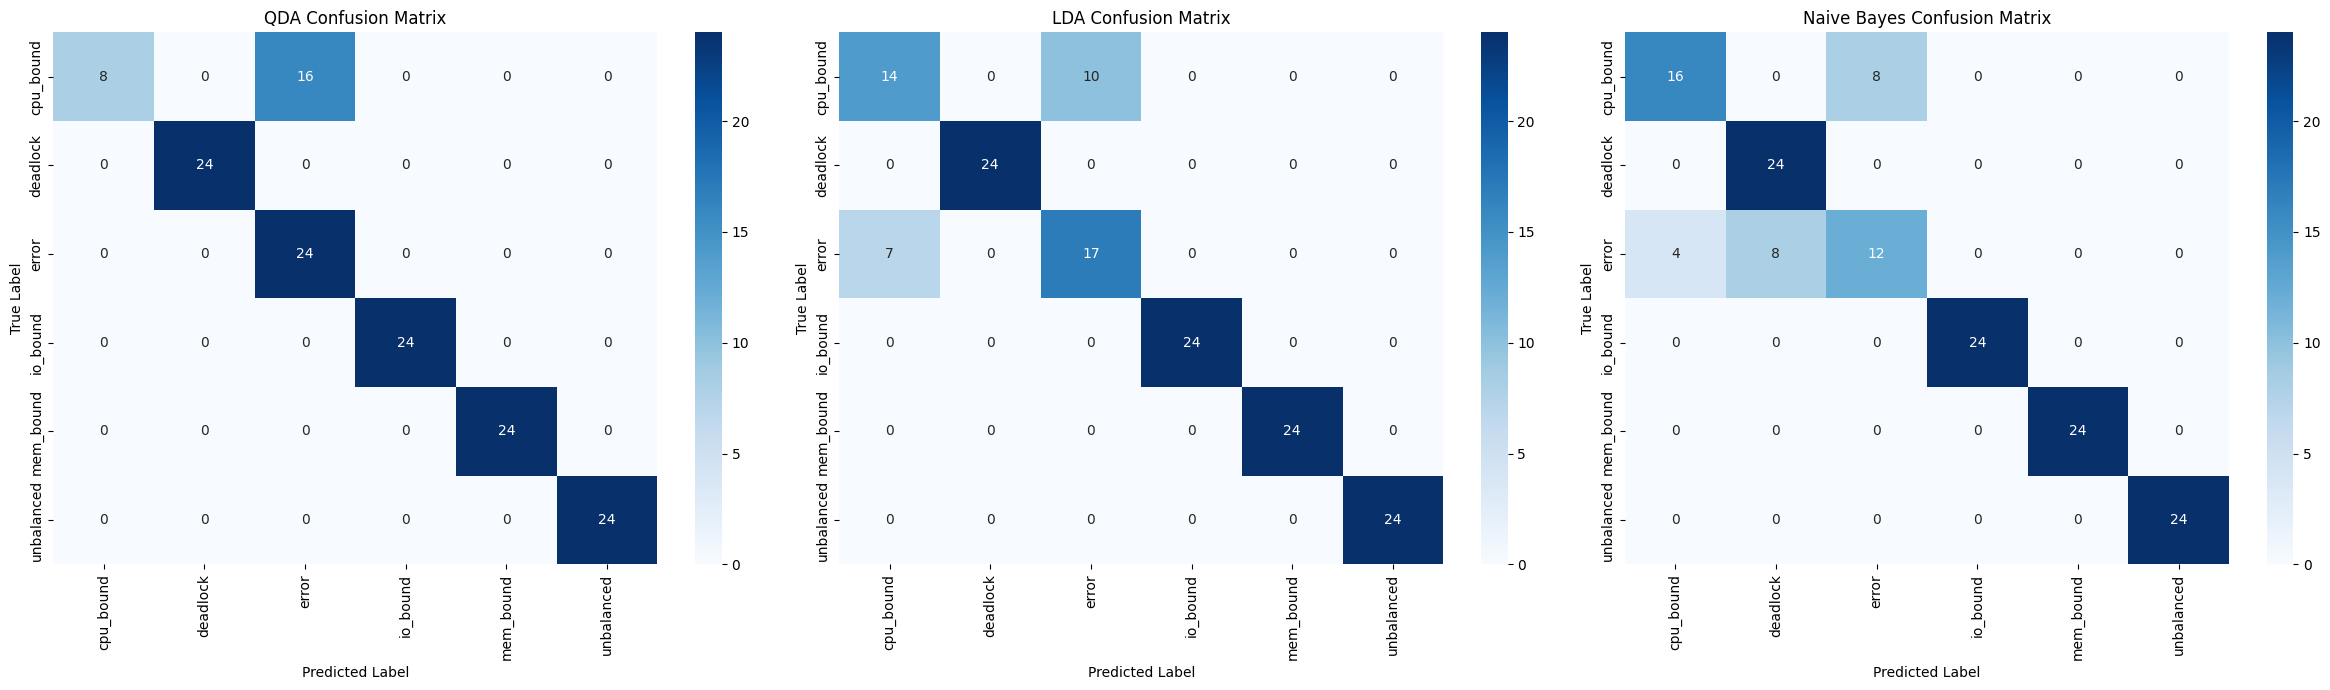

In [201]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

# Create QDA model
qda_model = QuadraticDiscriminantAnalysis(reg_param=1)

# Train QDA with top 10 features
qda_model.fit(X_train_top10_scaled, y_train)

# Make predictions with QDA
y_pred_qda = qda_model.predict(X_test_top10_scaled)

# Evaluate QDA performance
accuracy_qda = accuracy_score(y_test, y_pred_qda)
print(f"\nQDA Test Accuracy with top {num_of_features} features: {accuracy_qda:.4f}")
print(f"\nQDA Classification Report (Top {num_of_features} Features):")
print(classification_report(y_test, y_pred_qda))

# Create LDA model
lda_model = LinearDiscriminantAnalysis()

# Train LDA with top 10 features
lda_model.fit(X_train_top10_scaled, y_train)

# Make predictions with LDA
y_pred_lda = lda_model.predict(X_test_top10_scaled)

# Evaluate LDA performance
accuracy_lda = accuracy_score(y_test, y_pred_lda)
print(f"\nLDA Test Accuracy with top {num_of_features} features: {accuracy_lda:.4f}")
print(f"\nLDA Classification Report (Top {num_of_features} Features):")
print(classification_report(y_test, y_pred_lda))

print("\n--- Model Comparison ---")
print(f"Logistic Regression accuracy: {accuracy_top10:.4f}")
print(f"QDA accuracy: {accuracy_qda:.4f}")
print(f"LDA accuracy: {accuracy_lda:.4f}")

cv_scores_qda = cross_val_score(
    qda_model, X_top10_normalized, y, groups=groups,
    cv=group_kfold, scoring='accuracy'
)
print(f"\nQDA Cross-Validation Accuracy: {cv_scores_qda.mean():.4f} ± {cv_scores_qda.std():.4f}")

cv_scores_lda = cross_val_score(
    lda_model, X_top10_normalized, y, groups=groups,
    cv=group_kfold, scoring='accuracy'
)
print(f"\nLDA Cross-Validation Accuracy: {cv_scores_lda.mean():.4f} ± {cv_scores_lda.std():.4f}")

# fig, axes = plt.subplots(1, 2, figsize=(16, 7))

from sklearn.naive_bayes import GaussianNB

# Create Naive Bayes model
nb_model = GaussianNB()

# Train Naive Bayes with top 10 features
nb_model.fit(X_train_top10_scaled, y_train)

# Make predictions with Naive Bayes
y_pred_nb = nb_model.predict(X_test_top10_scaled)

# Evaluate Naive Bayes performance
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"\nNaive Bayes Test Accuracy with top 10 features: {accuracy_nb:.4f}")
print("\nNaive Bayes Classification Report (Top 10 Features):")
print(classification_report(y_test, y_pred_nb))

# Update model comparison
print("\n--- Model Comparison ---")
print(f"Logistic Regression accuracy: {accuracy_top10:.4f}")
print(f"QDA accuracy: {accuracy_qda:.4f}")
print(f"LDA accuracy: {accuracy_lda:.4f}")
print(f"Naive Bayes accuracy: {accuracy_nb:.4f}")

# Cross-validation for Naive Bayes
cv_scores_nb = cross_val_score(
    nb_model, X_top10_normalized, y, groups=groups,
    cv=group_kfold, scoring='accuracy'
)
cv_scores_lda = cross_val_score(
    lda_model, X_top10_normalized, y, groups=groups,
    cv=group_kfold, scoring='accuracy'
)
cv_scores_qda = cross_val_score(
    qda_model, X_top10_normalized, y, groups=groups,
    cv=group_kfold, scoring='accuracy'
)
print(f"\nNaive Bayes Cross-Validation Accuracy: {cv_scores_nb.mean():.4f} ± {cv_scores_nb.std():.4f}")
print(f"\nLDA Cross-Validation Accuracy: {cv_scores_lda.mean():.4f} ± {cv_scores_lda.std():.4f}")
print(f"\nQDA Cross-Validation Accuracy: {cv_scores_qda.mean():.4f} ± {cv_scores_qda.std():.4f}")

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# QDA confusion matrix
cm_qda = confusion_matrix(y_test, y_pred_qda)
sns.heatmap(
    cm_qda, annot=True, fmt='d', cmap='Blues',
    xticklabels=qda_model.classes_,
    yticklabels=qda_model.classes_,
    ax=axes[0]
)
axes[0].set_title('QDA Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# LDA confusion matrix
cm_lda = confusion_matrix(y_test, y_pred_lda)
sns.heatmap(
    cm_lda, annot=True, fmt='d', cmap='Blues',
    xticklabels=lda_model.classes_,
    yticklabels=lda_model.classes_,
    ax=axes[1]
)
axes[1].set_title('LDA Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# Naive Bayes confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(
    cm_nb, annot=True, fmt='d', cmap='Blues',
    xticklabels=nb_model.classes_,
    yticklabels=nb_model.classes_,
    ax=axes[2]
)
axes[2].set_title('Naive Bayes Confusion Matrix')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.show()

Coefficient table (Coefficient Std. error z-statistic p-value)
Log Reg
LDA
ROC Curve
QDA

### Can specific quantitative thresholds in key metrics reliably differentiate workloads?


Decision Tree Accuracy: 0.8333


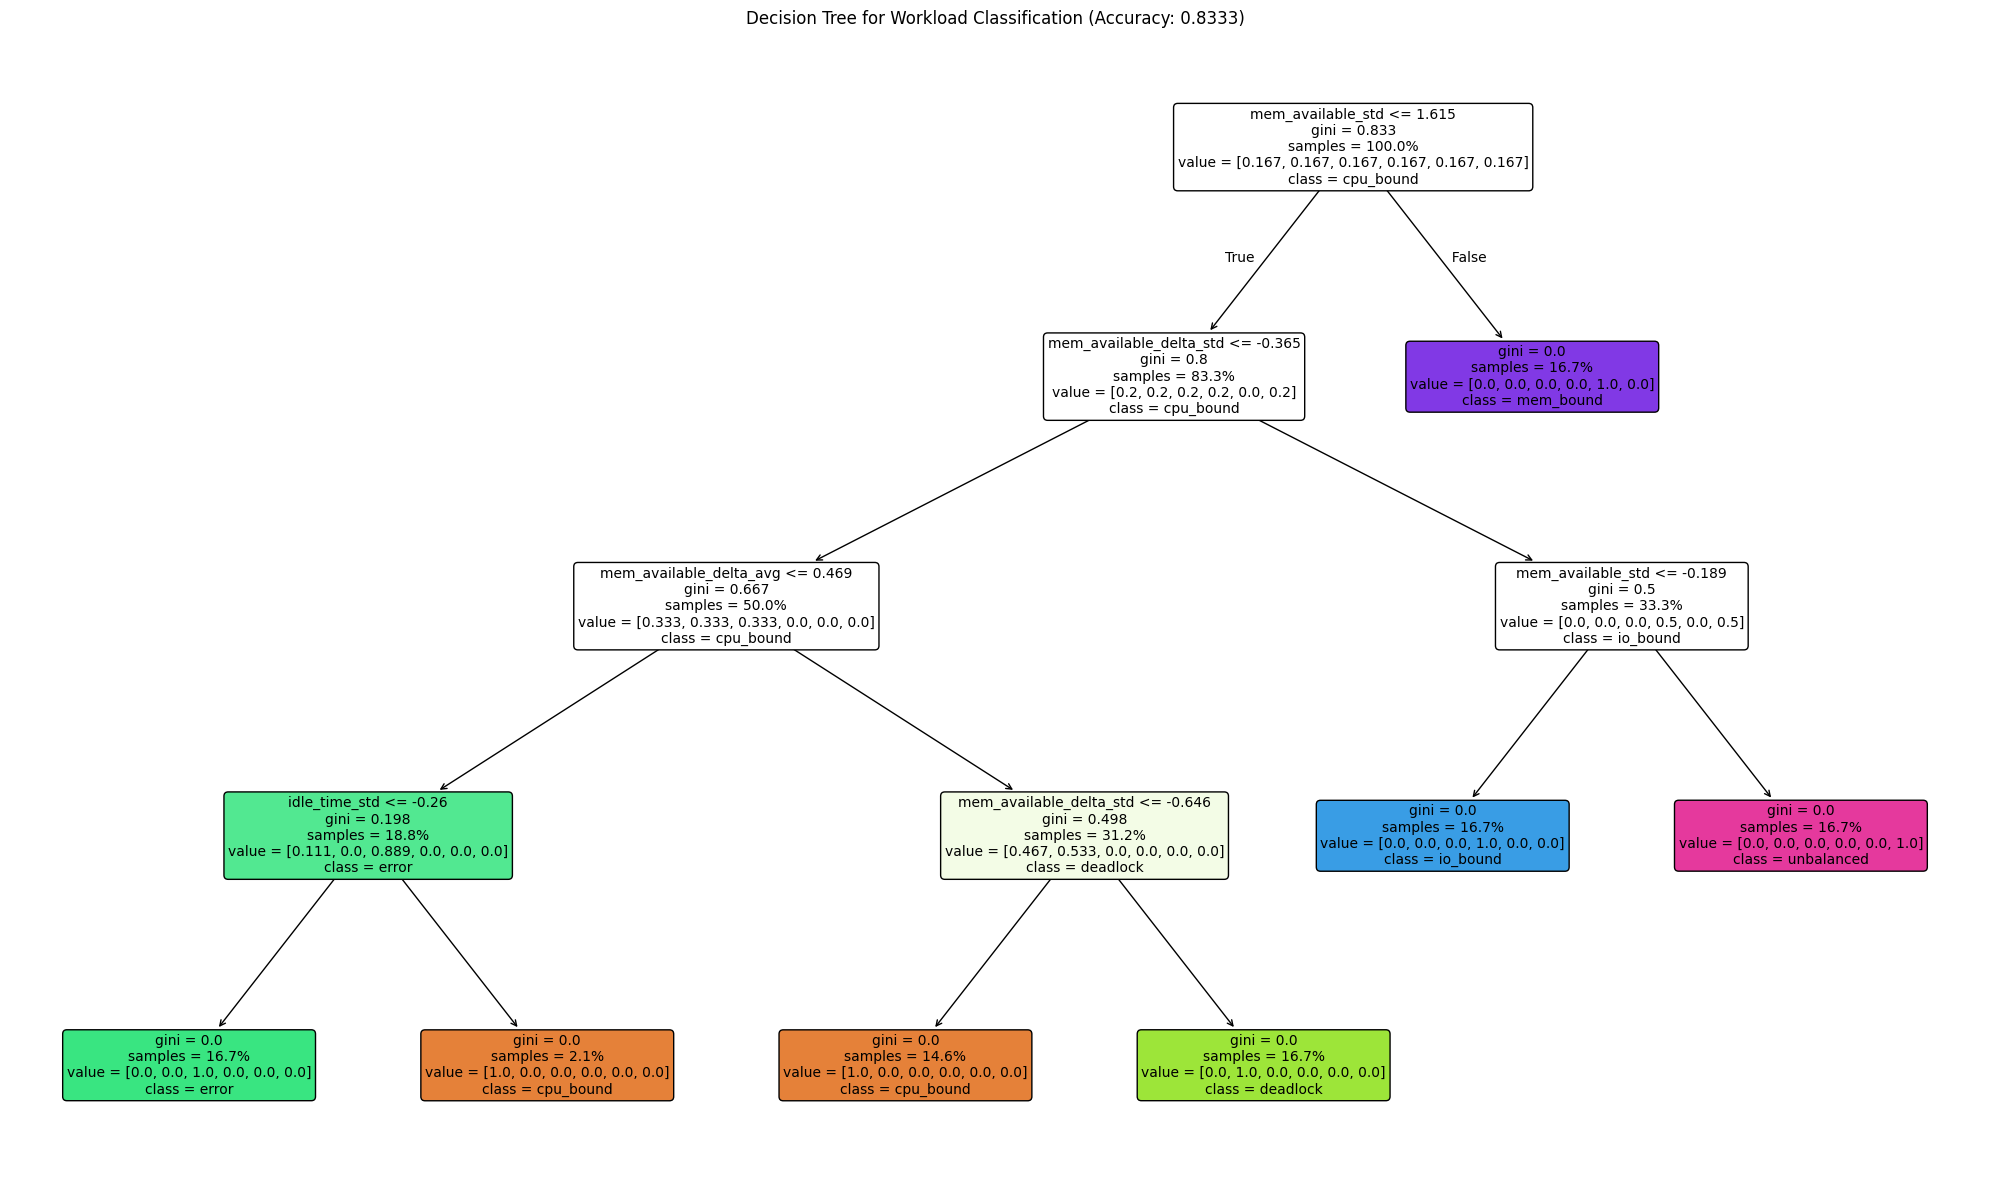

In [202]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create and train the tree
tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_model.fit(X_train_top10_scaled, y_train)
# Accuracy
tree_pred = tree_model.predict(X_test_top10_scaled)
tree_accuracy = accuracy_score(y_test, tree_pred)
print(f"Decision Tree Accuracy: {tree_accuracy:.4f}")

# # Create tree visualization
plt.figure(figsize=(20, 12))
plot_tree(tree_model, feature_names=top_features, class_names=list(tree_model.classes_), 
          filled=True, rounded=True, fontsize=10, proportion=True)
plt.title(f"Decision Tree for Workload Classification (Accuracy: {tree_accuracy:.4f})")
plt.tight_layout()
# plt.savefig("decision_tree_thresholds.png", dpi=300, bbox_inches='tight')
plt.show()

Top features: ['mem_available_std', 'mem_available_delta_std', 'mem_available_delta_avg', 'idle_time_std', 'mem_available_cv', 'iowait_percentage']


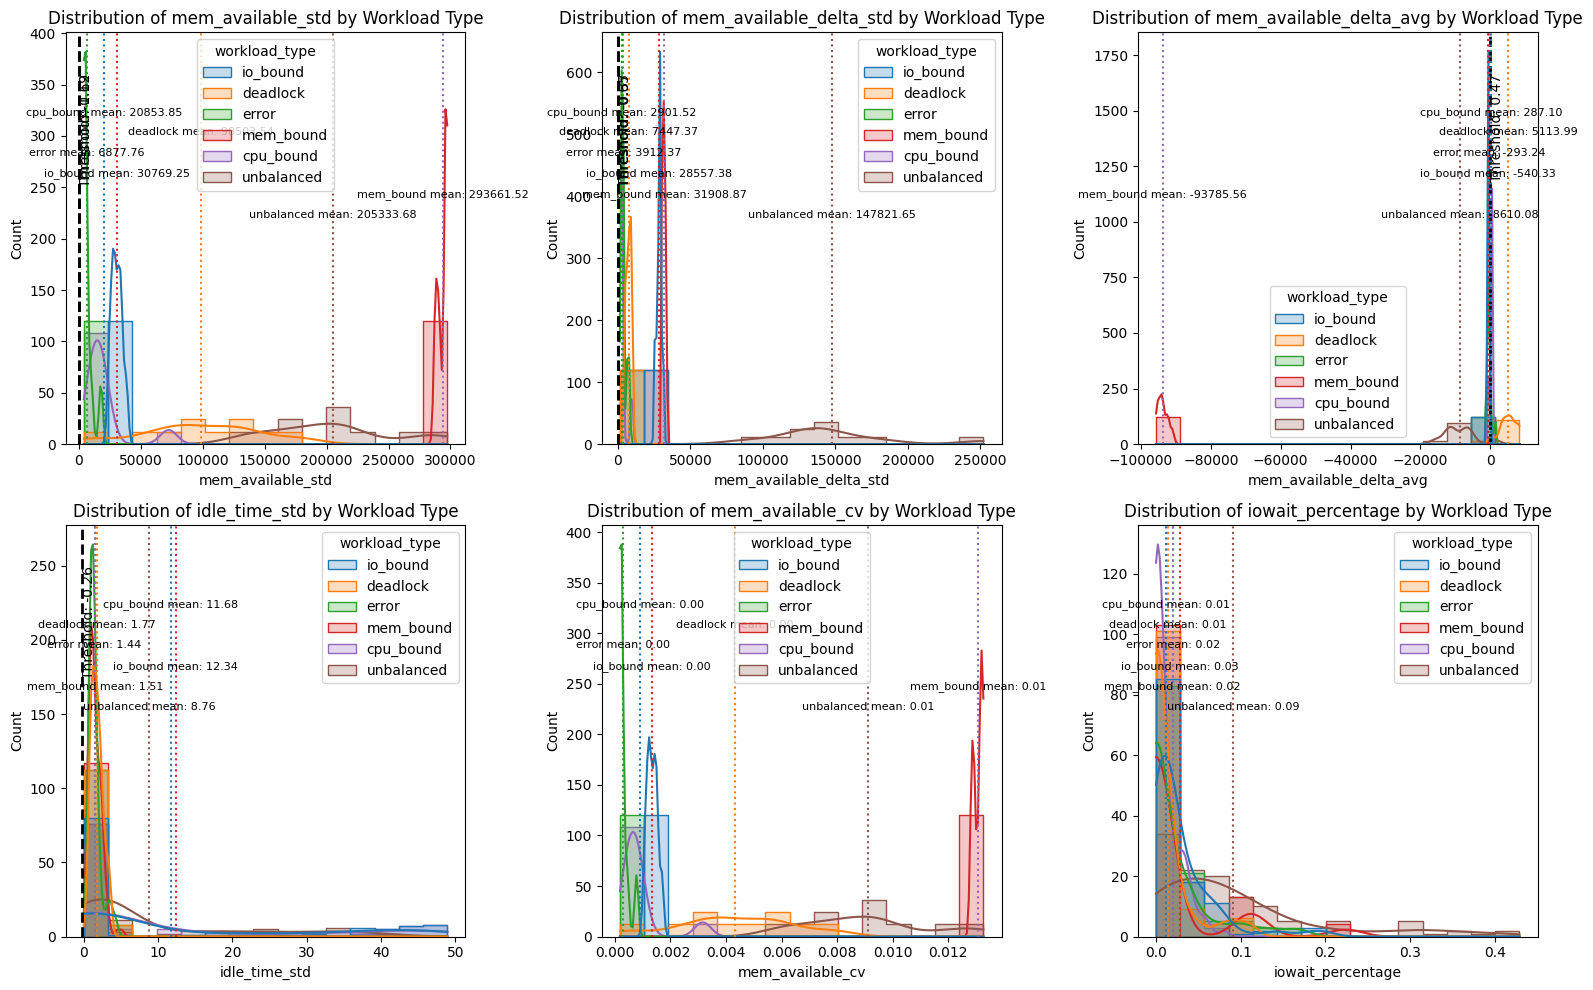

In [203]:
# Select top 6 features based on feature importance from tree
minimal_features = top_features
importances = tree_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': minimal_features, 'Importance': importances})
top_features = feature_importance.sort_values('Importance', ascending=False)['Feature'].head(6).tolist()

# Create histogram for each feature
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Debug print
print("Top features:", top_features)

# Create a combined dataframe with features and target
plot_data = pd.DataFrame(X)
plot_data['workload_type'] = y

for i, feature in enumerate(top_features):
    ax = axes[i]
    
    # Plot histogram for this feature by workload type
    sns.histplot(data=plot_data, x=feature, hue='workload_type', bins=15, 
                 kde=True, element='step', common_norm=False, ax=ax)
    
    # Add decision tree threshold lines if this feature appears in the tree
    for node_id in range(tree_model.tree_.node_count):
        if tree_model.tree_.feature[node_id] == list(minimal_features).index(feature):
            threshold = tree_model.tree_.threshold[node_id]
            ax.axvline(x=threshold, color='black', linestyle='--', linewidth=2)
            ax.text(threshold, ax.get_ylim()[1]*0.9, f'Threshold: {threshold:.2f}', 
                    rotation=90, verticalalignment='top')
    
    ax.set_title(f'Distribution of {feature} by Workload Type')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    
    # Calculate means for each workload type
    means = plot_data.groupby('workload_type')[feature].mean().to_dict()
    y_pos = ax.get_ylim()[1] * 0.8
    for j, (wl, mean_val) in enumerate(means.items()):
        ax.axvline(x=mean_val, color=sns.color_palette()[j], linestyle=':')
        ax.text(mean_val, y_pos - j*ax.get_ylim()[1]*0.05, 
                f'{wl} mean: {mean_val:.2f}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('feature_distributions_thresholds.png', dpi=300, bbox_inches='tight')
plt.show()

Looking at these histogram distributions, we can see clear patterns that help explain why the decision tree classifier and logistic regression achieved such high accuracy.

The memory metrics show the most dramatic separations. For mem_available_delta_std, unbalanced workloads stand out with a unique bimodal pattern, while memory-bound workloads show consistently higher values than CPU and I/O workloads. The mem_available_delta_avg plot clearly isolates memory-bound workloads with their strongly negative values, showing they consistently consume memory over time.

For the time-related metrics, idle_time_std gives us a useful signal for CPU-bound workloads, which show more variability in their idle patterns. The idle_time_percentage is particularly good at identifying deadlock conditions, which hover near 99% idle time – even a 1-2% difference here is significant for classification.

The active_memory_percentage chart shows an interesting multi-modal distribution that naturally separates different workload types: I/O-bound workloads cluster around 55%, memory-bound around 54.5%, and CPU-bound near 53%. These seemingly small percentage differences provide reliable boundaries for the decision tree to split on.

## Model Discussion

Of the three models, logistic regression, LDA, and QDA, logistic regression performed the best. Furthermore, only 10 features were necessary get 93% classification accuracy and achieve high F1 scores with statistical significance (chai square test). 

I expected naive bayes to perform well because I had many features and less observations. I would guess that QDA would perform better if I had more observations, and LDA did not perform well because of the many features. 

I was not expecting the models to turn out nearly as well as they did. Another thing I wanted to explore was my derived features. I wanted to make sure that the fact that multiple HWT observations shared the same memory did not make the data trivially classifiable. The decision tree shows that the memory statistics were very indicative of workload. The chai squared test confirmed that model results were not due to chance. 

Limitations of this model is that the dataset scripts did not include a mix of workloads. The scripts were specifically designed to be extremely evident of the type of workload. I would like to use this model on monitoring data on an application of unknown workload. 

In [204]:
def extract_tree_rules(tree, feature_names, class_names):
    """Extract rules from a decision tree."""
    tree_ = tree.tree_
    rules = []
    
    def recurse(node, depth, path):
        if tree_.feature[node] != -2:  # Not a leaf node
            name = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]
            
            # Left branch - feature <= threshold
            path_left = path.copy()
            path_left.append(f"{name} <= {threshold:.2f}")
            recurse(tree_.children_left[node], depth + 1, path_left)
            
            # Right branch - feature > threshold
            path_right = path.copy()
            path_right.append(f"{name} > {threshold:.2f}")
            recurse(tree_.children_right[node], depth + 1, path_right)
        else:  # Leaf node
            class_probabilities = tree_.value[node][0] / tree_.value[node][0].sum()
            predicted_class = class_names[np.argmax(class_probabilities)]
            max_prob = np.max(class_probabilities)
            
            if max_prob > 0.7:  # Only include rules with high confidence
                rule = {
                    'path': path.copy(),
                    'predicted_class': predicted_class,
                    'confidence': max_prob,
                    'samples': tree_.n_node_samples[node]
                }
                rules.append(rule)
    
    recurse(0, 1, [])
    return rules

# Extract key rules
tree_rules = extract_tree_rules(tree_model, minimal_features, list(tree_model.classes_))

# Display key thresholds
print("\nKey Thresholds for Workload Classification:")
for i, rule in enumerate(sorted(tree_rules, key=lambda x: x['confidence'], reverse=True)[:10]):
    path_str = " AND ".join(rule['path'])
    print(f"{i+1}. IF {path_str} THEN {rule['predicted_class']} (confidence: {rule['confidence']:.2f}, samples: {rule['samples']})")

# Create a comprehensive threshold table
threshold_counts = {}
for feature in minimal_features:
    threshold_counts[feature] = 0

for node_id in range(tree_model.tree_.node_count):
    feature_idx = tree_model.tree_.feature[node_id]
    if feature_idx != -2:  # Not a leaf node
        feature = minimal_features[feature_idx]
        threshold_counts[feature] += 1

# Show feature usage in decision rules
feature_usage = pd.DataFrame({
    'Feature': list(threshold_counts.keys()),
    'Times Used as Threshold': list(threshold_counts.values())
})
print("\nFeature Usage in Decision Thresholds:")
print(feature_usage.sort_values('Times Used as Threshold', ascending=False).head(10))


Key Thresholds for Workload Classification:
1. IF mem_available_std <= 1.62 AND mem_available_delta_std <= -0.37 AND mem_available_delta_avg <= 0.47 AND idle_time_std <= -0.26 THEN error (confidence: 1.00, samples: 96)
2. IF mem_available_std <= 1.62 AND mem_available_delta_std <= -0.37 AND mem_available_delta_avg <= 0.47 AND idle_time_std > -0.26 THEN cpu_bound (confidence: 1.00, samples: 12)
3. IF mem_available_std <= 1.62 AND mem_available_delta_std <= -0.37 AND mem_available_delta_avg > 0.47 AND mem_available_delta_std <= -0.65 THEN cpu_bound (confidence: 1.00, samples: 84)
4. IF mem_available_std <= 1.62 AND mem_available_delta_std <= -0.37 AND mem_available_delta_avg > 0.47 AND mem_available_delta_std > -0.65 THEN deadlock (confidence: 1.00, samples: 96)
5. IF mem_available_std <= 1.62 AND mem_available_delta_std > -0.37 AND mem_available_std <= -0.19 THEN io_bound (confidence: 1.00, samples: 96)
6. IF mem_available_std <= 1.62 AND mem_available_delta_std > -0.37 AND mem_availab

ZEROSUM -> FRONTIER XGC DATA

In [205]:
#| echo: false

import pandas as pd
import glob
import os
import numpy as np
import re

file_path = "frontier_dataset"
data_dfs = []
# numeric_cols = ["step", "value"]

# Check what files exist in the directory
# print(f"Directory exists: {os.path.exists(file_path)}")
# print(f"Directory contents: {os.listdir(file_path) if os.path.exists(file_path) else 'Directory not found'}")

# Try the glob pattern and see what it returns
example_data = glob.glob(f"{file_path}/*.csv")
# print(f"Files found by glob: {example_data}")

# Only proceed if files were found
if example_data:
    for d, data_file in enumerate(example_data):
        try:
            df = pd.read_csv(data_file, delimiter=",", dtype=str)

            mask = df["name"] != "state"
            df.loc[mask, "value"] = pd.to_numeric(df.loc[mask, "value"], errors='coerce')
            df["index"] = pd.to_numeric(df["index"], errors='coerce')

           # Get only LWP data
            hwt_df = df[df["resource"] == "HWT"].copy()
            mem_df = df[df["resource"] == "Node"].copy()
            lwp_df = df[df["resource"] == "LWP"].copy()
            gpu_df = df[df["resource"] == "GPU"].copy()

            hwt_dfs = [group for _, group in hwt_df.groupby('index')]
            # print(f"{example_data[d]} made {len(hwt_dfs)} pids")

            lwp_dfs = [group for _, group in lwp_df.groupby('index')]
            # print(f"{example_data[d]} made {len(lwp_dfs)} tids")

            for ldf in lwp_dfs:
                # Create a mask for rows where name is processor
                mask2 = ldf['name'] == "processor"
                # Get unique values from the value column where the mask is True
                processor_values = ldf.loc[mask2, 'value'].unique().tolist()
                # print(f"processors: {processor_values}")
                
                for p in processor_values:
                    for hdf in hwt_dfs:
                        # Get the unique index value for this hwt dataframe
                        hwt_index = hdf['index'].iloc[0]  # Assuming index is consistent within a group
                        if hwt_index == p:
                            # Concatenate the thread dataframe with matching processor dataframe
                            data_dfs.append(pd.concat([ldf, hdf, mem_df, gpu_df]))

            # print(f"Successfully read: {data_file}")
        except Exception as e:
            print(f"Error reading {data_file}: {e}")
else:
    print("No CSV files found in the specified directory.")

In [206]:
attr = pd.DataFrame(data_dfs[0])
print(attr['name'].unique().tolist())

['majflt', 'minflt', 'nonvoluntary_ctxt_switches', 'nswap', 'processor', 'pthread lock calls', 'pthread trylock calls', 'state', 'step', 'stime', 'utime', 'voluntary_ctxt_switches', 'guest', 'guest_nice', 'idle', 'idle_all', 'iowait', 'irq', 'nice', 'softirq', 'steal', 'system', 'system_all', 'total_time', 'user', 'virt_all_time', 'MemAvailable kB', 'MemFree kB', 'MemTotal kB', 'cray_pm accel0_energy (J)', 'cray_pm accel0_power (W)', 'cray_pm accel1_energy (J)', 'cray_pm accel1_power (W)', 'cray_pm accel2_energy (J)', 'cray_pm accel2_power (W)', 'cray_pm accel3_energy (J)', 'cray_pm accel3_power (W)', 'cray_pm cpu0_temp (C)', 'cray_pm cpu_energy (J)', 'cray_pm cpu_power (W)', 'cray_pm energy (J)', 'cray_pm memory_energy (J)', 'cray_pm memory_power (W)', 'cray_pm power (W)', 'cray_pm power cap changed', 'cray_pm valid', 'Bus ID', 'Can Map Host Memory', 'Clock Instruction Rate', 'Clock Rate', 'Compute Mode', 'Concurrent Kernels', 'GPU_ID', 'Is Multi GPU Board', 'L2 Cache Size', 'Major Co

### Can unsupervised learning on the Frontier dataset reveal useful utilization insights on applications like XGC?

In [207]:
#| echo: false

def generate_features(data_dfs):
    agg_features = []
    agg_data_dfs = data_dfs.copy()

    for i, df in enumerate(agg_data_dfs):
        # Common values for all new rows
        hostname = df["hostname"].iloc[0] if "hostname" in df.columns and not df["hostname"].empty else None
        rank = df["rank"].iloc[0] if "rank" in df.columns and not df["rank"].empty else None
        shmrank = df["shmrank"].iloc[0] if "shmrank" in df.columns and not df["shmrank"].empty else None
        resource = "derived"
        type_val = "summary"
        index = df["index"].iloc[0] if "index" in df.columns and not df["index"].empty else 0
        step = df["step"].iloc[0] if "step" in df.columns and not df["step"].empty else 0
        
        # ---------- CPU Metrics ----------
        # Calculate base metrics
        idle_times = sum(df[df["name"] == "idle_all"]["value"].tolist()) if "idle_all" in df["name"].values else 0
        user_times = sum(df[df["name"] == "user"]["value"].tolist()) if "user" in df["name"].values else 0
        system_times = sum(df[df["name"] == "system"]["value"].tolist()) if "system" in df["name"].values else 0
        iowait_times = sum(df[df["name"] == "iowait"]["value"].tolist()) if "iowait" in df["name"].values else 0
        total_time = idle_times + user_times + system_times + iowait_times
        
        # Get lists of values for calculating standard deviations
        idle_values = df[df["name"] == "idle_all"]["value"].tolist() if "idle_all" in df["name"].values else []
        user_values = df[df["name"] == "user"]["value"].tolist() if "user" in df["name"].values else []
        system_values = df[df["name"] == "system"]["value"].tolist() if "system" in df["name"].values else []
        iowait_values = df[df["name"] == "iowait"]["value"].tolist() if "iowait" in df["name"].values else []
        
        # Calculate standard deviations (handle empty lists)
        idle_std = np.std(idle_values) if idle_values else 0
        user_std = np.std(user_values) if user_values else 0
        system_std = np.std(system_values) if system_values else 0
        iowait_std = np.std(iowait_values) if iowait_values else 0

        # ---------- Memory Metrics ----------
        # Get memory metrics if they exist
        mem_total = sum(df[df["name"] == "MemTotal kB"]["value"].astype(float).tolist()) if "MemTotal kB" in df["name"].values else 0
        mem_available = sum(df[df["name"] == "MemAvailable kB"]["value"].astype(float).tolist()) if "MemAvailable kB" in df["name"].values else 0
        mem_free = sum(df[df["name"] == "MemFree kB"]["value"].astype(float).tolist()) if "MemFree kB" in df["name"].values else 0

        # Memory related values
        mem_total_values = df[df["name"] == "MemTotal kB"]["value"].astype(float).tolist() if "MemTotal kB" in df["name"].values else []
        mem_available_values = df[df["name"] == "MemAvailable kB"]["value"].astype(float).tolist() if "MemAvailable kB" in df["name"].values else []
        mem_free_values = df[df["name"] == "MemFree kB"]["value"].astype(float).tolist() if "MemFree kB" in df["name"].values else []
        
        mem_total_std = np.std(mem_total_values) if mem_total_values else 0
        mem_available_std = np.std(mem_available_values) if mem_available_values else 0
        mem_free_std = np.std(mem_free_values) if mem_free_values else 0

        # ---------- GPU Metrics ----------
        # Extract GPU metrics
        gpu_clock_glx = sum(df[df["name"] == "Clock Frequency, GLX (MHz)"]["value"].astype(float).tolist()) if "Clock Frequency, GLX (MHz)" in df["name"].values else 0
        gpu_clock_soc = sum(df[df["name"] == "Clock Frequency, SOC (MHz)"]["value"].astype(float).tolist()) if "Clock Frequency, SOC (MHz)" in df["name"].values else 0
        gpu_busy = sum(df[df["name"] == "Device Busy %"]["value"].astype(float).tolist()) if "Device Busy %" in df["name"].values else 0
        gpu_energy = sum(df[df["name"] == "Energy Average (J)"]["value"].astype(float).tolist()) if "Energy Average (J)" in df["name"].values else 0
        gpu_gfx_activity = sum(df[df["name"] == "GFX Activity"]["value"].astype(float).tolist()) if "GFX Activity" in df["name"].values else 0
        gpu_gfx_activity_pct = sum(df[df["name"] == "GFX Activity %"]["value"].astype(float).tolist()) if "GFX Activity %" in df["name"].values else 0
        gpu_mem_activity_pct = sum(df[df["name"] == "Memory Activity %"]["value"].astype(float).tolist()) if "Memory Activity %" in df["name"].values else 0
        gpu_mem_busy = sum(df[df["name"] == "Memory Busy %"]["value"].astype(float).tolist()) if "Memory Busy %" in df["name"].values else 0
        gpu_mem_controller = sum(df[df["name"] == "Memory Controller Activity"]["value"].astype(float).tolist()) if "Memory Controller Activity" in df["name"].values else 0
        gpu_throttle = sum(df[df["name"] == "Throttle Status"]["value"].astype(float).tolist()) if "Throttle Status" in df["name"].values else 0
        
        # GPU memory usage
        gpu_total_gtt = sum(df[df["name"] == "Total GTT Bytes"]["value"].astype(float).tolist()) if "Total GTT Bytes" in df["name"].values else 0
        gpu_total_vram = sum(df[df["name"] == "Total VRAM Bytes"]["value"].astype(float).tolist()) if "Total VRAM Bytes" in df["name"].values else 0
        gpu_used_gtt = sum(df[df["name"] == "Used GTT Bytes"]["value"].astype(float).tolist()) if "Used GTT Bytes" in df["name"].values else 0
        gpu_used_vram = sum(df[df["name"] == "Used VRAM Bytes"]["value"].astype(float).tolist()) if "Used VRAM Bytes" in df["name"].values else 0
        
        # Lists for standard deviations
        gpu_clock_glx_values = df[df["name"] == "Clock Frequency, GLX (MHz)"]["value"].astype(float).tolist() if "Clock Frequency, GLX (MHz)" in df["name"].values else []
        gpu_clock_soc_values = df[df["name"] == "Clock Frequency, SOC (MHz)"]["value"].astype(float).tolist() if "Clock Frequency, SOC (MHz)" in df["name"].values else []
        gpu_busy_values = df[df["name"] == "Device Busy %"]["value"].astype(float).tolist() if "Device Busy %" in df["name"].values else []
        gpu_energy_values = df[df["name"] == "Energy Average (J)"]["value"].astype(float).tolist() if "Energy Average (J)" in df["name"].values else []
        gpu_mem_busy_values = df[df["name"] == "Memory Busy %"]["value"].astype(float).tolist() if "Memory Busy %" in df["name"].values else []
        gpu_used_vram_values = df[df["name"] == "Used VRAM Bytes"]["value"].astype(float).tolist() if "Used VRAM Bytes" in df["name"].values else []
        
        # Calculate standard deviations for GPU metrics
        gpu_clock_glx_std = np.std(gpu_clock_glx_values) if gpu_clock_glx_values else 0
        gpu_clock_soc_std = np.std(gpu_clock_soc_values) if gpu_clock_soc_values else 0
        gpu_busy_std = np.std(gpu_busy_values) if gpu_busy_values else 0
        gpu_energy_std = np.std(gpu_energy_values) if gpu_energy_values else 0
        gpu_mem_busy_std = np.std(gpu_mem_busy_values) if gpu_mem_busy_values else 0
        gpu_used_vram_std = np.std(gpu_used_vram_values) if gpu_used_vram_values else 0

        # ---------- Power Metrics ----------
        # Extract power metrics
        total_power = sum(df[df["name"] == "cray_pm power (W)"]["value"].astype(float).tolist()) if "cray_pm power (W)" in df["name"].values else 0
        total_energy = sum(df[df["name"] == "cray_pm energy (J)"]["value"].astype(float).tolist()) if "cray_pm energy (J)" in df["name"].values else 0
        cpu_power = sum(df[df["name"] == "cray_pm cpu_power (W)"]["value"].astype(float).tolist()) if "cray_pm cpu_power (W)" in df["name"].values else 0
        cpu_energy = sum(df[df["name"] == "cray_pm cpu_energy (J)"]["value"].astype(float).tolist()) if "cray_pm cpu_energy (J)" in df["name"].values else 0
        memory_power = sum(df[df["name"] == "cray_pm memory_power (W)"]["value"].astype(float).tolist()) if "cray_pm memory_power (W)" in df["name"].values else 0
        memory_energy = sum(df[df["name"] == "cray_pm memory_energy (J)"]["value"].astype(float).tolist()) if "cray_pm memory_energy (J)" in df["name"].values else 0
        
        # Accelerator power metrics
        accel0_power = sum(df[df["name"] == "cray_pm accel0_power (W)"]["value"].astype(float).tolist()) if "cray_pm accel0_power (W)" in df["name"].values else 0
        accel0_energy = sum(df[df["name"] == "cray_pm accel0_energy (J)"]["value"].astype(float).tolist()) if "cray_pm accel0_energy (J)" in df["name"].values else 0
        accel1_power = sum(df[df["name"] == "cray_pm accel1_power (W)"]["value"].astype(float).tolist()) if "cray_pm accel1_power (W)" in df["name"].values else 0
        accel1_energy = sum(df[df["name"] == "cray_pm accel1_energy (J)"]["value"].astype(float).tolist()) if "cray_pm accel1_energy (J)" in df["name"].values else 0
        accel2_power = sum(df[df["name"] == "cray_pm accel2_power (W)"]["value"].astype(float).tolist()) if "cray_pm accel2_power (W)" in df["name"].values else 0
        accel2_energy = sum(df[df["name"] == "cray_pm accel2_energy (J)"]["value"].astype(float).tolist()) if "cray_pm accel2_energy (J)" in df["name"].values else 0
        accel3_power = sum(df[df["name"] == "cray_pm accel3_power (W)"]["value"].astype(float).tolist()) if "cray_pm accel3_power (W)" in df["name"].values else 0
        accel3_energy = sum(df[df["name"] == "cray_pm accel3_energy (J)"]["value"].astype(float).tolist()) if "cray_pm accel3_energy (J)" in df["name"].values else 0
        
        # Temperature
        cpu_temp = sum(df[df["name"] == "cray_pm cpu0_temp (C)"]["value"].astype(float).tolist()) if "cray_pm cpu0_temp (C)" in df["name"].values else 0
        
        # Lists for standard deviations
        total_power_values = df[df["name"] == "cray_pm power (W)"]["value"].astype(float).tolist() if "cray_pm power (W)" in df["name"].values else []
        cpu_power_values = df[df["name"] == "cray_pm cpu_power (W)"]["value"].astype(float).tolist() if "cray_pm cpu_power (W)" in df["name"].values else []
        memory_power_values = df[df["name"] == "cray_pm memory_power (W)"]["value"].astype(float).tolist() if "cray_pm memory_power (W)" in df["name"].values else []
        accel0_power_values = df[df["name"] == "cray_pm accel0_power (W)"]["value"].astype(float).tolist() if "cray_pm accel0_power (W)" in df["name"].values else []
        accel1_power_values = df[df["name"] == "cray_pm accel1_power (W)"]["value"].astype(float).tolist() if "cray_pm accel1_power (W)" in df["name"].values else []
        accel2_power_values = df[df["name"] == "cray_pm accel2_power (W)"]["value"].astype(float).tolist() if "cray_pm accel2_power (W)" in df["name"].values else []
        accel3_power_values = df[df["name"] == "cray_pm accel3_power (W)"]["value"].astype(float).tolist() if "cray_pm accel3_power (W)" in df["name"].values else []
        cpu_temp_values = df[df["name"] == "cray_pm cpu0_temp (C)"]["value"].astype(float).tolist() if "cray_pm cpu0_temp (C)" in df["name"].values else []
        
        # Calculate standard deviations for power metrics
        total_power_std = np.std(total_power_values) if total_power_values else 0
        cpu_power_std = np.std(cpu_power_values) if cpu_power_values else 0
        memory_power_std = np.std(memory_power_values) if memory_power_values else 0
        accel0_power_std = np.std(accel0_power_values) if accel0_power_values else 0
        accel1_power_std = np.std(accel1_power_values) if accel1_power_values else 0
        accel2_power_std = np.std(accel2_power_values) if accel2_power_values else 0
        accel3_power_std = np.std(accel3_power_values) if accel3_power_values else 0
        cpu_temp_std = np.std(cpu_temp_values) if cpu_temp_values else 0

        # ---------- Process/Thread Metrics ----------
        # Extract LWP metrics
        if "majflt" in df["name"].values:
            lwp_majflt = sum(df[df["name"] == "majflt"]["value"].astype(float).tolist())
            lwp_majflt_values = df[df["name"] == "majflt"]["value"].astype(float).tolist()
            lwp_majflt_std = np.std(lwp_majflt_values) if lwp_majflt_values else 0
        else:
            lwp_majflt = 0
            lwp_majflt_std = 0
            
        if "minflt" in df["name"].values:
            lwp_minflt = sum(df[df["name"] == "minflt"]["value"].astype(float).tolist())
            lwp_minflt_values = df[df["name"] == "minflt"]["value"].astype(float).tolist()
            lwp_minflt_std = np.std(lwp_minflt_values) if lwp_minflt_values else 0
        else:
            lwp_minflt = 0
            lwp_minflt_std = 0
            
        if "nonvoluntary_ctxt_switches" in df["name"].values:
            lwp_nonvol_ctx = sum(df[df["name"] == "nonvoluntary_ctxt_switches"]["value"].astype(float).tolist())
            lwp_nonvol_ctx_values = df[df["name"] == "nonvoluntary_ctxt_switches"]["value"].astype(float).tolist()
            lwp_nonvol_ctx_std = np.std(lwp_nonvol_ctx_values) if lwp_nonvol_ctx_values else 0
        else:
            lwp_nonvol_ctx = 0
            lwp_nonvol_ctx_std = 0
            
        if "voluntary_ctxt_switches" in df["name"].values:
            lwp_vol_ctx = sum(df[df["name"] == "voluntary_ctxt_switches"]["value"].astype(float).tolist())
            lwp_vol_ctx_values = df[df["name"] == "voluntary_ctxt_switches"]["value"].astype(float).tolist()
            lwp_vol_ctx_std = np.std(lwp_vol_ctx_values) if lwp_vol_ctx_values else 0
        else:
            lwp_vol_ctx = 0
            lwp_vol_ctx_std = 0
            
        if "utime" in df["name"].values:
            lwp_utime = sum(df[df["name"] == "utime"]["value"].astype(float).tolist())
            lwp_utime_values = df[df["name"] == "utime"]["value"].astype(float).tolist()
            lwp_utime_std = np.std(lwp_utime_values) if lwp_utime_values else 0
        else:
            lwp_utime = 0
            lwp_utime_std = 0
            
        if "stime" in df["name"].values:
            lwp_stime = sum(df[df["name"] == "stime"]["value"].astype(float).tolist())
            lwp_stime_values = df[df["name"] == "stime"]["value"].astype(float).tolist()
            lwp_stime_std = np.std(lwp_stime_values) if lwp_stime_values else 0
        else:
            lwp_stime = 0
            lwp_stime_std = 0

        # Create new rows for derived metrics
        new_rows = []
        
        # --------- CPU Mean Metrics ---------
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "user_time_percentage",
            "value": (user_times / total_time * 100) if total_time > 0 else 0
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "system_time_percentage",
            "value": (system_times / total_time * 100) if total_time > 0 else 0
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "idle_time_percentage",
            "value": (idle_times / total_time * 100) if total_time > 0 else 0
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "iowait_percentage",
            "value": (iowait_times / total_time * 100) if total_time > 0 else 0
        })
        
        # --------- CPU Standard Deviation Metrics ---------
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "user_time_std",
            "value": user_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "system_time_std",
            "value": system_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "idle_time_std",
            "value": idle_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "iowait_time_std",
            "value": iowait_std
        })
        
        # --------- Memory Mean Metrics ---------
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "memory_utilization",
            "value": ((mem_total - mem_available) / mem_total * 100) if mem_total > 0 else 0
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "memory_fragmentation",
            "value": ((mem_available - mem_free) / mem_total * 100) if mem_total > 0 else 0
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "active_memory_percentage",
            "value": ((mem_total - mem_free) / mem_total * 100) if mem_total > 0 else 0
        })
        
        # --------- Memory Standard Deviation Metrics ---------
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "mem_total_std",
            "value": mem_total_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "mem_available_std",
            "value": mem_available_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "mem_free_std",
            "value": mem_free_std
        })
        
        # --------- GPU Mean Metrics ---------
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "gpu_vram_utilization",
            "value": (gpu_used_vram / gpu_total_vram * 100) if gpu_total_vram > 0 else 0
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "gpu_gtt_utilization",
            "value": (gpu_used_gtt / gpu_total_gtt * 100) if gpu_total_gtt > 0 else 0
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "gpu_busy_percentage",
            "value": gpu_busy
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "gpu_mem_busy_percentage",
            "value": gpu_mem_busy
        })
        
        # --------- GPU Standard Deviation Metrics ---------
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "gpu_clock_glx_std",
            "value": gpu_clock_glx_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "gpu_clock_soc_std",
            "value": gpu_clock_soc_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "gpu_busy_std",
            "value": gpu_busy_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "gpu_mem_busy_std",
            "value": gpu_mem_busy_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "gpu_used_vram_std",
            "value": gpu_used_vram_std
        })
        
        # --------- Power Mean Metrics ---------
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "total_power",
            "value": total_power
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "cpu_power",
            "value": cpu_power
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "memory_power",
            "value": memory_power
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "accel0_power",
            "value": accel0_power
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "accel1_power",
            "value": accel1_power
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "accel2_power",
            "value": accel2_power
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "accel3_power",
            "value": accel3_power
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "cpu_temp",
            "value": cpu_temp
        })
        
        # --------- Power Standard Deviation Metrics ---------
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "total_power_std",
            "value": total_power_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "cpu_power_std",
            "value": cpu_power_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "memory_power_std",
            "value": memory_power_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "accel0_power_std",
            "value": accel0_power_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "accel1_power_std",
            "value": accel1_power_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "accel2_power_std",
            "value": accel2_power_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "accel3_power_std",
            "value": accel3_power_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "cpu_temp_std",
            "value": cpu_temp_std
        })
        
        # --------- Process/Thread Mean Metrics ---------
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "lwp_majflt",
            "value": lwp_majflt
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "lwp_minflt",
            "value": lwp_minflt
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "lwp_nonvol_ctx",
            "value": lwp_nonvol_ctx
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "lwp_vol_ctx",
            "value": lwp_vol_ctx
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "lwp_utime",
            "value": lwp_utime
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "lwp_stime",
            "value": lwp_stime
        })
        
        # --------- Process/Thread Standard Deviation Metrics ---------
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "lwp_majflt_std",
            "value": lwp_majflt_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "lwp_minflt_std",
            "value": lwp_minflt_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "lwp_nonvol_ctx_std",
            "value": lwp_nonvol_ctx_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "lwp_vol_ctx_std",
            "value": lwp_vol_ctx_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "lwp_utime_std",
            "value": lwp_utime_std
        })
        
        new_rows.append({
            "hostname": hostname,
            "rank": rank,
            "shmrank": shmrank,
            "step": step,
            "resource": resource,
            "type": type_val,
            "index": index,
            "name": "lwp_stime_std",
            "value": lwp_stime_std
        })
        
        # Calculate delta features (for metrics that have sequences)
        delta_metrics = []
        
        # Only calculate deltas if we have enough sequential samples
        if len(user_values) > 1:
            # Sort values by sequence order if there's an index column
            if "index" in df.columns:
                sorted_indices = np.argsort(df[df["name"] == "user"]["index"].values)
                sorted_user_values = np.array(user_values)[sorted_indices]
                sorted_system_values = np.array(system_values)[sorted_indices]
                
                if iowait_values:
                    sorted_iowait_values = np.array(iowait_values)[sorted_indices]
                else:
                    sorted_iowait_values = []
                    
                # Calculate deltas for CPU metrics
                if len(sorted_user_values) > 1:
                    user_deltas = np.diff(sorted_user_values)
                    avg_user_delta = np.mean(user_deltas)
                    user_delta_std = np.std(user_deltas)
                    
                    delta_metrics.append({
                        "hostname": hostname,
                        "rank": rank,
                        "shmrank": shmrank,
                        "step": step,
                        "resource": resource,
                        "type": type_val,
                        "index": index,
                        "name": "user_time_delta_avg",
                        "value": avg_user_delta
                    })
                
            # LWP/Thread deltas
            if len(lwp_utime_values) > 1 and "index" in df.columns:
                lwp_indices = np.argsort(df[df["name"] == "utime"]["index"].values)
                sorted_lwp_utime = np.array(lwp_utime_values)[lwp_indices]
                sorted_lwp_stime = np.array(lwp_stime_values)[lwp_indices] if len(lwp_stime_values) > 1 else []
                
                if len(sorted_lwp_utime) > 1:
                    lwp_utime_deltas = np.diff(sorted_lwp_utime)
                    avg_lwp_utime_delta = np.mean(lwp_utime_deltas)
                    lwp_utime_delta_std = np.std(lwp_utime_deltas)
                    
                    delta_metrics.append({
                        "hostname": hostname,
                        "rank": rank,
                        "shmrank": shmrank,
                        "step": step,
                        "resource": resource,
                        "type": type_val,
                        "index": index,
                        "name": "lwp_utime_delta_avg",
                        "value": avg_lwp_utime_delta
                    })
                    
                    delta_metrics.append({
                        "hostname": hostname,
                        "rank": rank,
                        "shmrank": shmrank,
                        "step": step,
                        "resource": resource,
                        "type": type_val,
                        "index": index,
                        "name": "lwp_utime_delta_std",
                        "value": lwp_utime_delta_std
                    })
                
                if len(sorted_lwp_stime) > 1:
                    lwp_stime_deltas = np.diff(sorted_lwp_stime)
                    avg_lwp_stime_delta = np.mean(lwp_stime_deltas)
                    lwp_stime_delta_std = np.std(lwp_stime_deltas)
                    
                    delta_metrics.append({
                        "hostname": hostname,
                        "rank": rank,
                        "shmrank": shmrank,
                        "step": step,
                        "resource": resource,
                        "type": type_val,
                        "index": index,
                        "name": "lwp_stime_delta_avg",
                        "value": avg_lwp_stime_delta
                    })
                    
                    delta_metrics.append({
                        "hostname": hostname,
                        "rank": rank,
                        "shmrank": shmrank,
                        "step": step,
                        "resource": resource,
                        "type": type_val,
                        "index": index,
                        "name": "lwp_stime_delta_std",
                        "value": lwp_stime_delta_std
                    })

                    delta_metrics.append({
                        "hostname": hostname,
                        "rank": rank,
                        "shmrank": shmrank,
                        "step": step,
                        "resource": resource,
                        "type": type_val,
                        "index": index,
                        "name": "user_time_delta_std",
                        "value": user_delta_std
                    })
                
                if len(sorted_system_values) > 1:
                    system_deltas = np.diff(sorted_system_values)
                    avg_system_delta = np.mean(system_deltas)
                    system_delta_std = np.std(system_deltas)
                    
                    delta_metrics.append({
                        "hostname": hostname,
                        "rank": rank,
                        "shmrank": shmrank,
                        "step": step,
                        "resource": resource,
                        "type": type_val,
                        "index": index,
                        "name": "system_time_delta_avg",
                        "value": avg_system_delta
                    })
                    
                    delta_metrics.append({
                        "hostname": hostname,
                        "rank": rank,
                        "shmrank": shmrank,
                        "step": step,
                        "resource": resource,
                        "type": type_val,
                        "index": index,
                        "name": "system_time_delta_std",
                        "value": system_delta_std
                    })
                
                if len(sorted_iowait_values) > 1:
                    iowait_deltas = np.diff(sorted_iowait_values)
                    avg_iowait_delta = np.mean(iowait_deltas)
                    iowait_delta_std = np.std(iowait_deltas)
                    
                    delta_metrics.append({
                        "hostname": hostname,
                        "rank": rank,
                        "shmrank": shmrank,
                        "step": step,
                        "resource": resource,
                        "type": type_val,
                        "index": index,
                        "name": "iowait_time_delta_avg",
                        "value": avg_iowait_delta
                    })
                    
                    delta_metrics.append({
                        "hostname": hostname,
                        "rank": rank,
                        "shmrank": shmrank,
                        "step": step,
                        "resource": resource,
                        "type": type_val,
                        "index": index,
                        "name": "iowait_time_delta_std",
                        "value": iowait_delta_std
                    })
            
            # Memory deltas
            if len(mem_available_values) > 1 and "index" in df.columns:
                mem_indices = np.argsort(df[df["name"] == "MemAvailable kB"]["index"].values)
                sorted_mem_available = np.array(mem_available_values)[mem_indices]
                
                mem_deltas = np.diff(sorted_mem_available)
                avg_mem_delta = np.mean(mem_deltas)
                mem_delta_std = np.std(mem_deltas)
                
                delta_metrics.append({
                    "hostname": hostname,
                    "rank": rank,
                    "shmrank": shmrank,
                    "step": step,
                    "resource": resource,
                    "type": type_val,
                    "index": index,
                    "name": "mem_available_delta_avg",
                    "value": avg_mem_delta
                })
                
                delta_metrics.append({
                    "hostname": hostname,
                    "rank": rank,
                    "shmrank": shmrank,
                    "step": step,
                    "resource": resource,
                    "type": type_val,
                    "index": index,
                    "name": "mem_available_delta_std",
                    "value": mem_delta_std
                })
            
            # GPU deltas
            if len(gpu_busy_values) > 1 and "index" in df.columns:
                gpu_indices = np.argsort(df[df["name"] == "Device Busy %"]["index"].values)
                sorted_gpu_busy = np.array(gpu_busy_values)[gpu_indices]
                
                gpu_busy_deltas = np.diff(sorted_gpu_busy)
                avg_gpu_busy_delta = np.mean(gpu_busy_deltas)
                gpu_busy_delta_std = np.std(gpu_busy_deltas)
                
                delta_metrics.append({
                    "hostname": hostname,
                    "rank": rank,
                    "shmrank": shmrank,
                    "step": step,
                    "resource": resource,
                    "type": type_val,
                    "index": index,
                    "name": "gpu_busy_delta_avg",
                    "value": avg_gpu_busy_delta
                })
                
                delta_metrics.append({
                    "hostname": hostname,
                    "rank": rank,
                    "shmrank": shmrank,
                    "step": step,
                    "resource": resource,
                    "type": type_val,
                    "index": index,
                    "name": "gpu_busy_delta_std",
                    "value": gpu_busy_delta_std
                })
            
            # Power deltas
            if len(total_power_values) > 1 and "index" in df.columns:
                power_indices = np.argsort(df[df["name"] == "cray_pm power (W)"]["index"].values)
                sorted_total_power = np.array(total_power_values)[power_indices]
                
                power_deltas = np.diff(sorted_total_power)
                avg_power_delta = np.mean(power_deltas)
                power_delta_std = np.std(power_deltas)
                
                delta_metrics.append({
                    "hostname": hostname,
                    "rank": rank,
                    "shmrank": shmrank,
                    "step": step,
                    "resource": resource,
                    "type": type_val,
                    "index": index,
                    "name": "total_power_delta_avg",
                    "value": avg_power_delta
                })
                
                delta_metrics.append({
                    "hostname": hostname,
                    "rank": rank,
                    "shmrank": shmrank,
                    "step": step,
                    "resource": resource,
                    "type": type_val,
                    "index": index,
                    "name": "total_power_delta_std",
                    "value": power_delta_std
                })
                    
        # Add all metrics to agg_features
        agg_features.extend(new_rows)
        agg_features.extend(delta_metrics)
        
    return agg_features

derived_data = generate_features(data_dfs)
                    

In [208]:
#| echo: false

all_data = pd.DataFrame(derived_data)
print(all_data.columns)

# Pivot the data
pivot_df = all_data.pivot_table(
    index=['hostname', 'rank', 'shmrank', 'index'],
    columns='name',
    values='value',
    aggfunc='first'
)

# Reset the index
pivot_df = pivot_df.reset_index()

# Features (X data) - all columns except the identifier columns
X = pivot_df.drop(['hostname', 'rank', 'shmrank', 'index'], axis=1)
X = X.dropna(axis=1)

print("Feature matrix shape:", X.shape)
print("Feature columns:", X.columns)



Index(['hostname', 'rank', 'shmrank', 'step', 'resource', 'type', 'index',
       'name', 'value'],
      dtype='object')
Feature matrix shape: (1088, 67)
Feature columns: Index(['accel0_power', 'accel0_power_std', 'accel1_power', 'accel1_power_std',
       'accel2_power', 'accel2_power_std', 'accel3_power', 'accel3_power_std',
       'active_memory_percentage', 'cpu_power', 'cpu_power_std', 'cpu_temp',
       'cpu_temp_std', 'gpu_busy_delta_avg', 'gpu_busy_delta_std',
       'gpu_busy_percentage', 'gpu_busy_std', 'gpu_clock_glx_std',
       'gpu_clock_soc_std', 'gpu_gtt_utilization', 'gpu_mem_busy_percentage',
       'gpu_mem_busy_std', 'gpu_used_vram_std', 'gpu_vram_utilization',
       'idle_time_percentage', 'idle_time_std', 'iowait_percentage',
       'iowait_time_delta_avg', 'iowait_time_delta_std', 'iowait_time_std',
       'lwp_majflt', 'lwp_majflt_std', 'lwp_minflt', 'lwp_minflt_std',
       'lwp_nonvol_ctx', 'lwp_nonvol_ctx_std', 'lwp_stime',
       'lwp_stime_delta_avg', 'lw

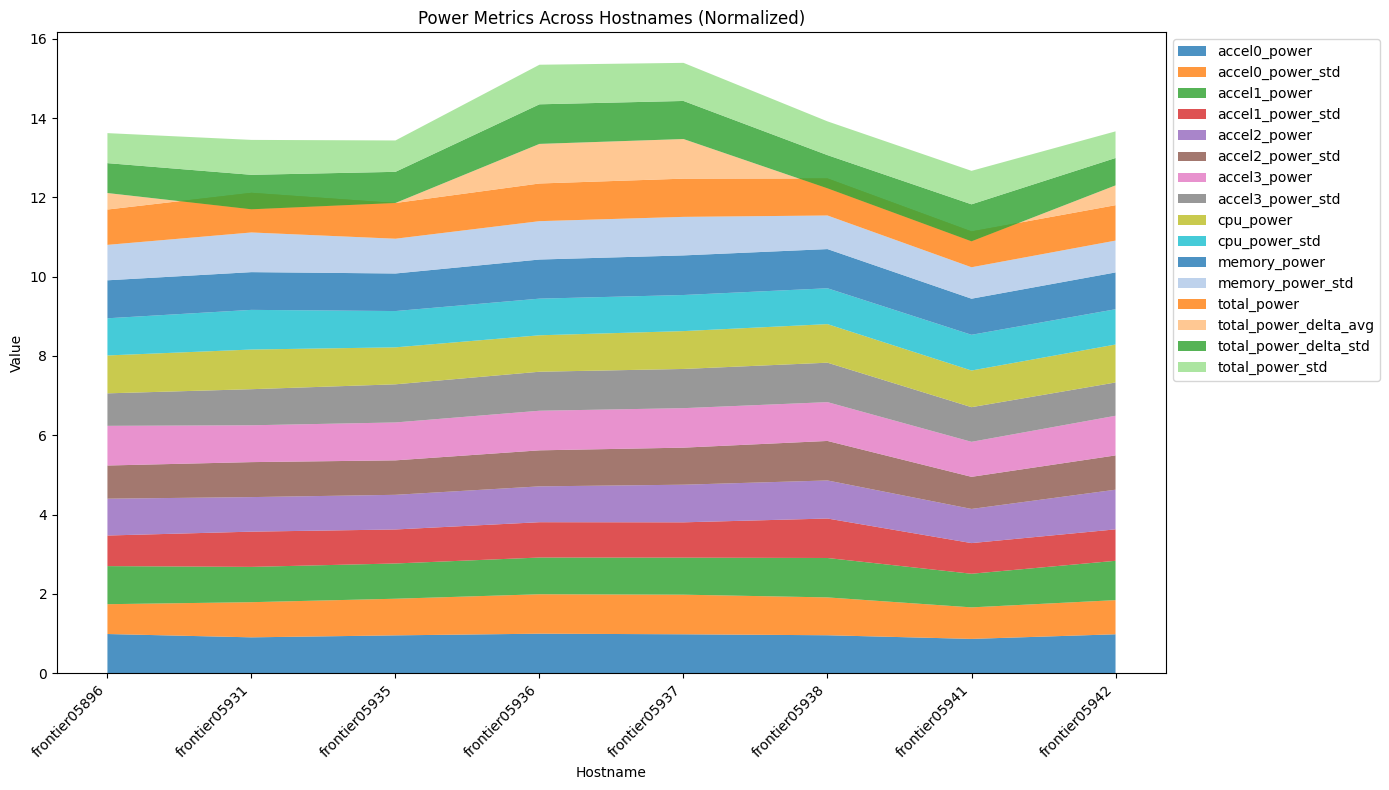

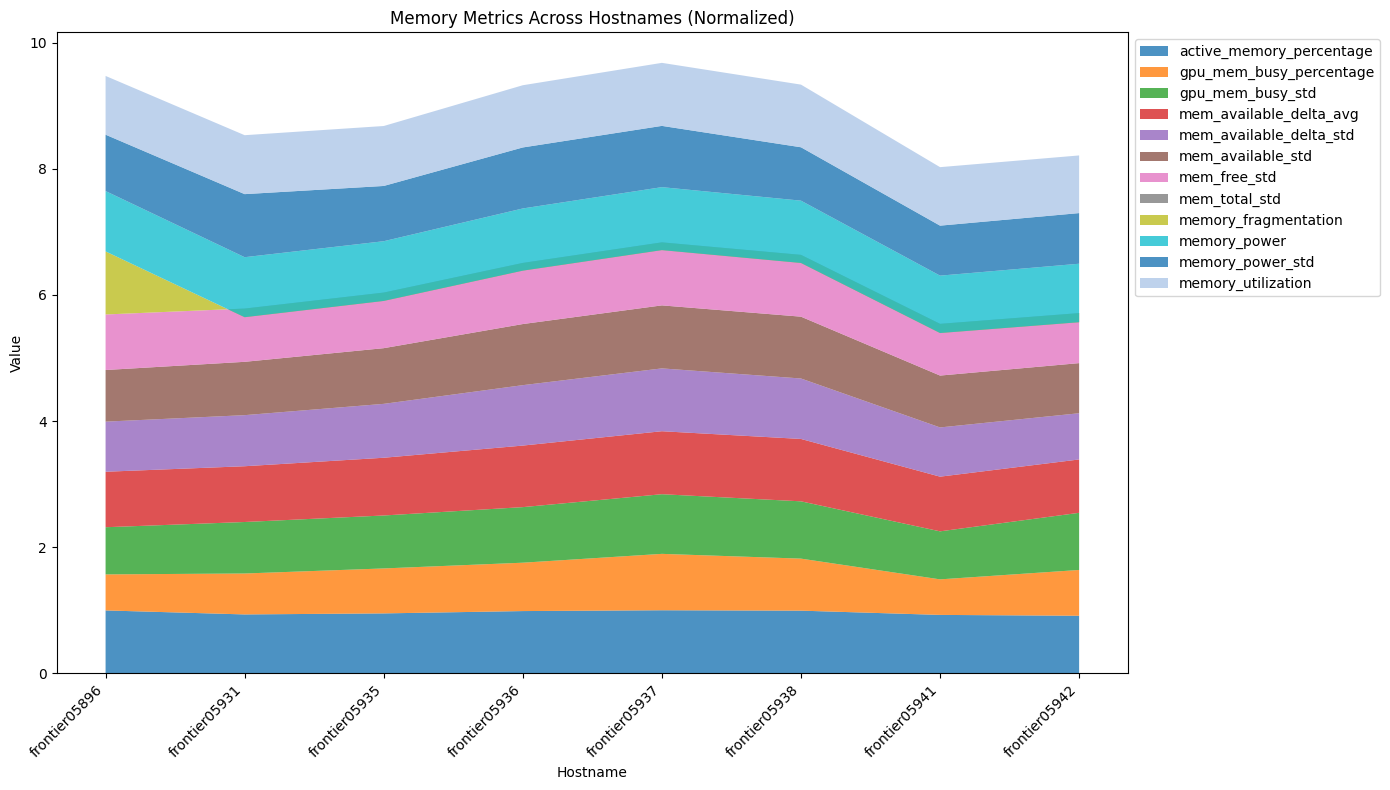

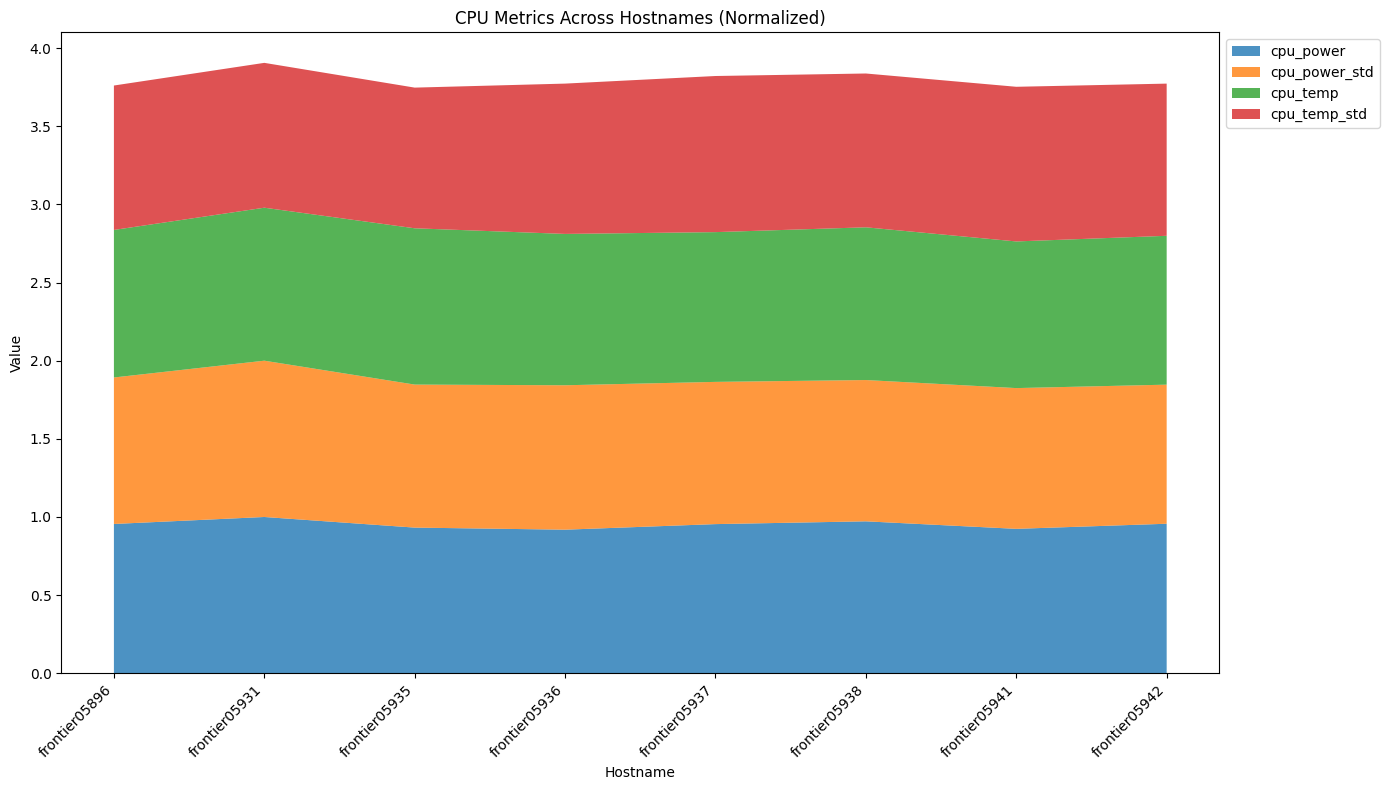

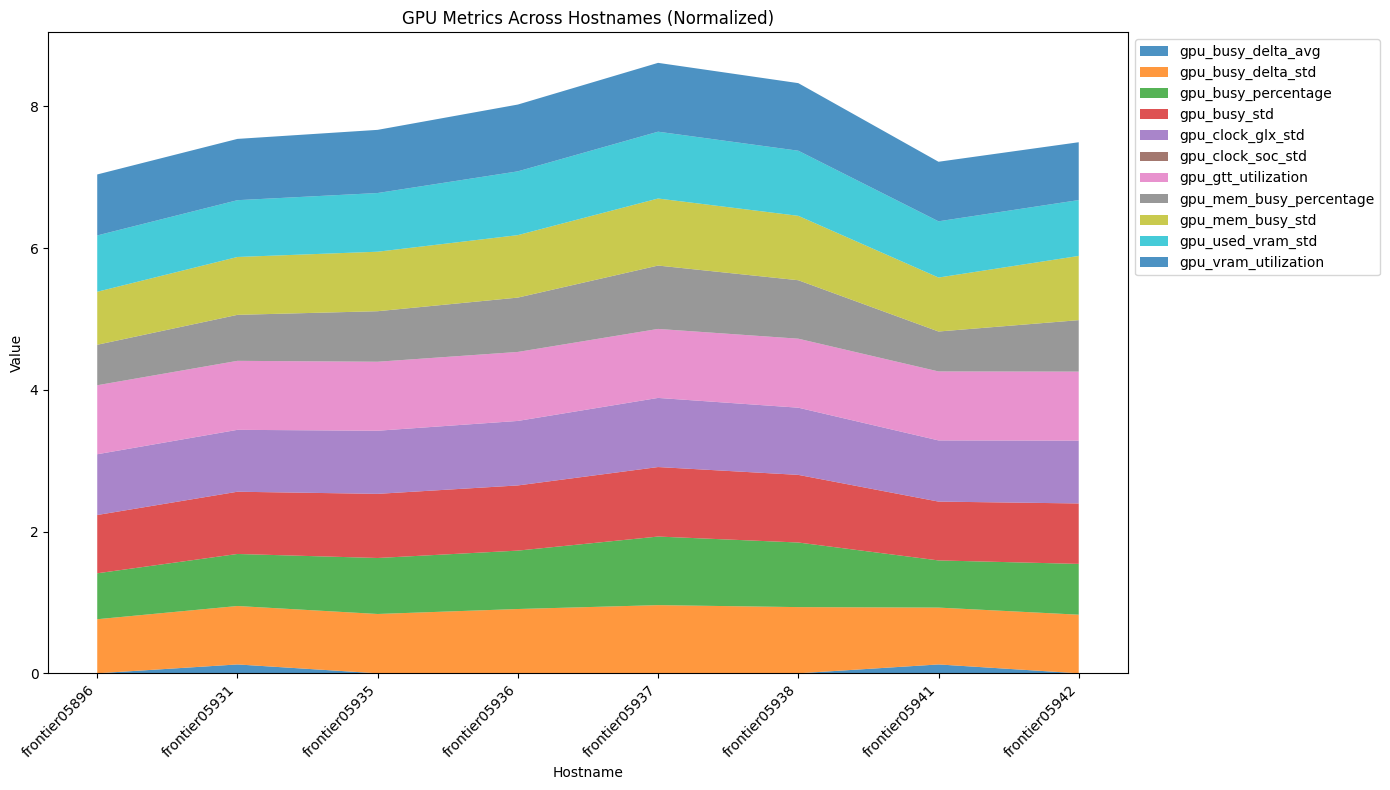

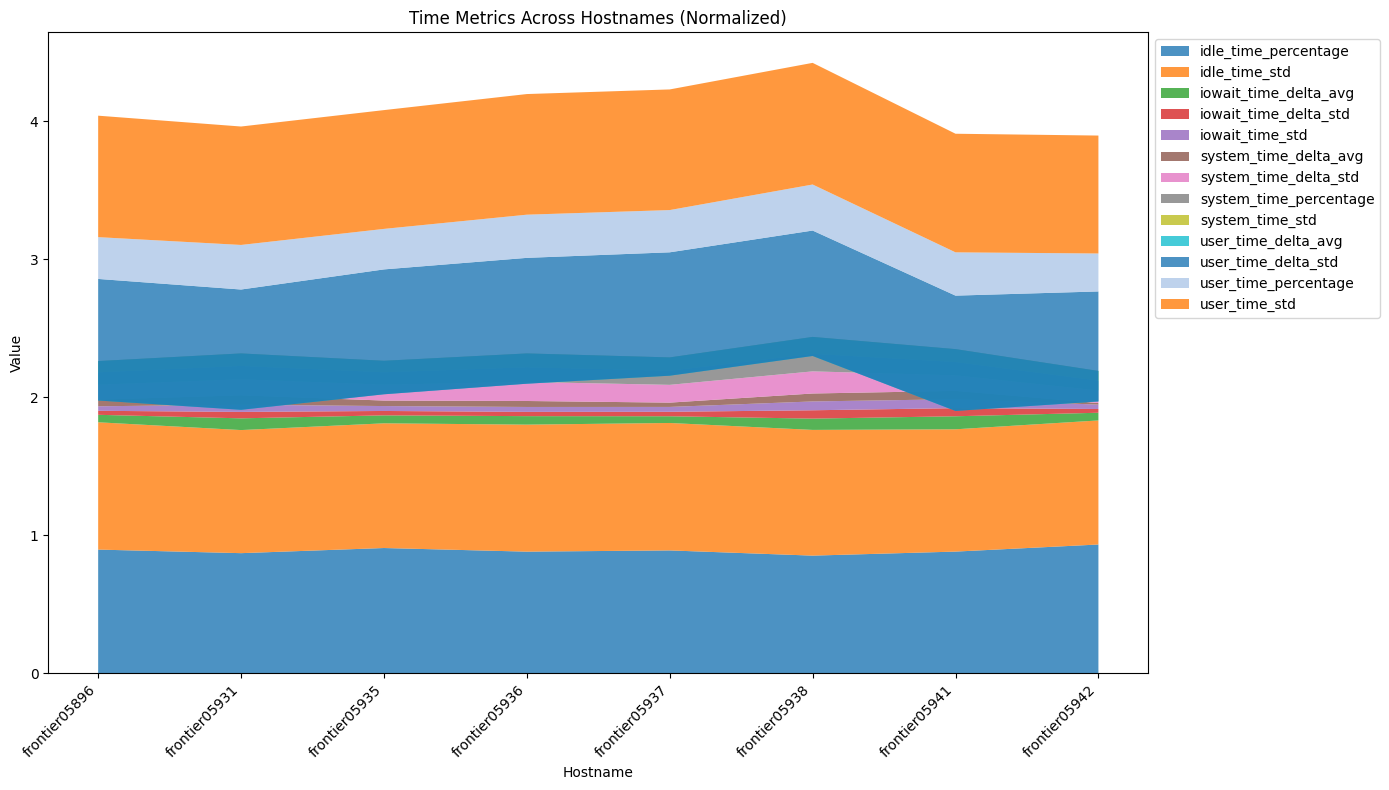

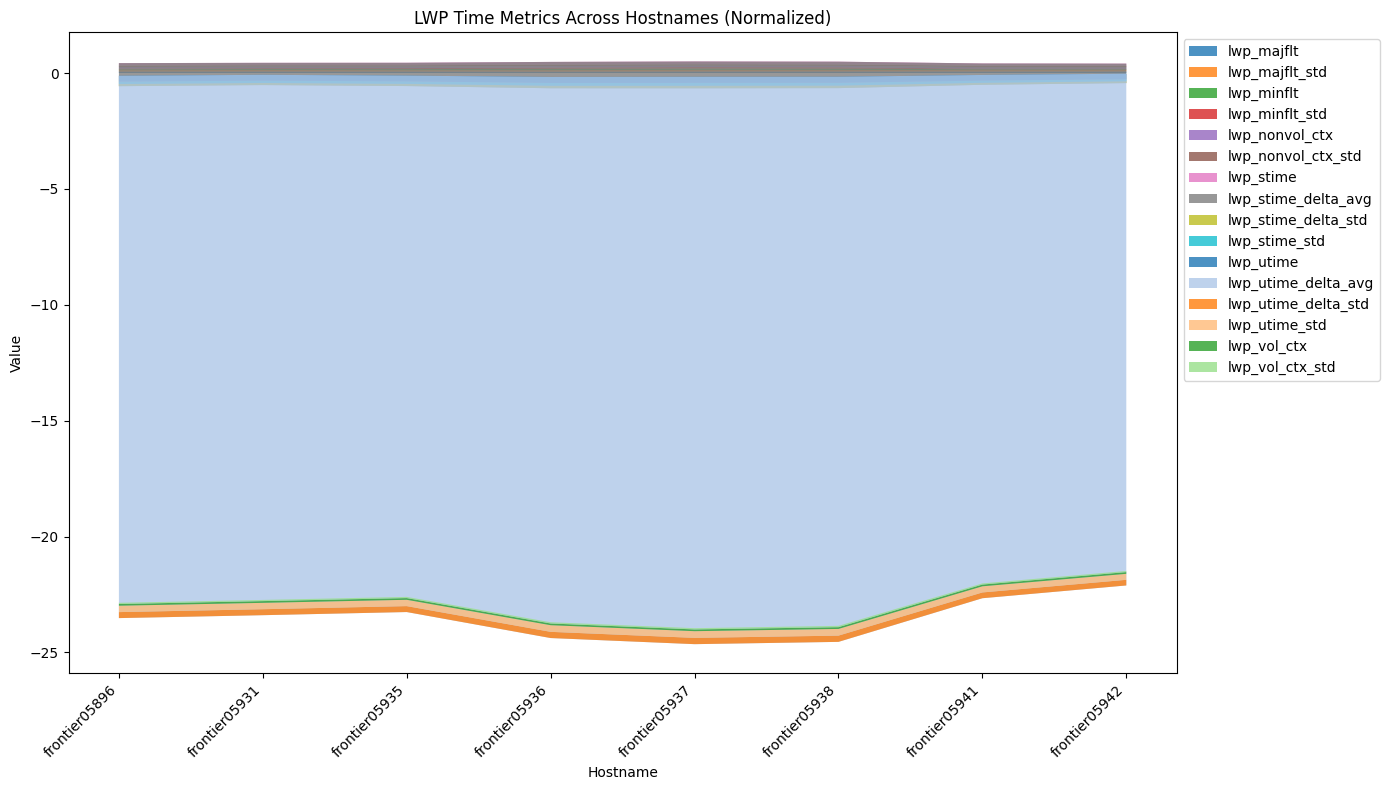

In [209]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def get_combined_colormap(n_colors):
    """Generate a large number of distinct colors by combining multiple colormaps"""
    # Collect colors from various colormaps
    tab10_colors = plt.colormaps['tab10'](np.linspace(0, 1, 10))
    tab20_colors = plt.colormaps['tab20'](np.linspace(0, 1, 20))
    tab20b_colors = plt.colormaps['tab20b'](np.linspace(0, 1, 20))
    tab20c_colors = plt.colormaps['tab20c'](np.linspace(0, 1, 20))
    
    # Combine all colors
    all_colors = np.vstack([tab10_colors, tab20_colors, tab20b_colors, tab20c_colors])
    
    # Return the requested number of colors (with cycling if needed)
    return all_colors[:n_colors % len(all_colors)]

# Group related metrics for better visualization
def create_metric_groups(feature_columns):
    power_metrics = [col for col in feature_columns if 'power' in col]
    memory_metrics = [col for col in feature_columns if any(x in col for x in ['memory', 'mem'])]
    cpu_metrics = [col for col in feature_columns if 'cpu' in col]
    gpu_metrics = [col for col in feature_columns if 'gpu' in col]
    time_metrics = [col for col in feature_columns if 'time' in col and 'lwp' not in col]    
    lwp_metrics = [col for col in feature_columns if 'lwp' in col]
    
    return {
        'Power': power_metrics,
        'Memory': memory_metrics,
        'CPU': cpu_metrics,
        'GPU': gpu_metrics,
        'Time': time_metrics,
        'LWP Time': lwp_metrics
    }

# Function to create stack plots by hostname
def create_stack_plot_by_metrics(pivot_df, metric_group_name, metrics, normalize=True, figsize=(14, 8)):
    """
    Create stack plots for a group of related metrics across different hostnames
    """
    # Select data for the metrics
    plot_data = pivot_df[['hostname'] + metrics].copy()
    
    # Normalize the data if requested
    if normalize:
        for metric in metrics:
            max_val = plot_data[metric].max()
            if max_val > 0:  # Avoid division by zero
                plot_data[metric] = plot_data[metric] / max_val
    
    # Group by hostname and calculate mean of each metric
    grouped_data = plot_data.groupby('hostname')[metrics].mean()
    
    # Create the stack plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get hostnames for x-axis
    hostnames = grouped_data.index
    
    # Prepare data for stacking
    stacked_data = np.zeros((len(metrics), len(hostnames)))
    for i, metric in enumerate(metrics):
        stacked_data[i] = grouped_data[metric].values

    colors = get_combined_colormap(len(metrics))
    
    # Create stack plot
    ax.stackplot(range(len(hostnames)), stacked_data, labels=metrics, alpha=0.8, colors=colors)
    
    # Customize the plot
    ax.set_title(f'{metric_group_name} Metrics Across Hostnames {"(Normalized)" if normalize else ""}')
    ax.set_xticks(range(len(hostnames)))
    ax.set_xticklabels(hostnames, rotation=45, ha='right')
    ax.set_xlabel('Hostname')
    ax.set_ylabel('Value')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create multiple stack plots for each metric group
def create_all_stack_plots(pivot_df, normalize=True):
    # Create metric groups
    metric_groups = create_metric_groups(pivot_df.columns)
    
    # Create a stack plot for each group
    figures = {}
    for group_name, metrics in metric_groups.items():
        if metrics:  # Only if we have metrics in this group
            figures[group_name] = create_stack_plot_by_metrics(
                pivot_df, 
                group_name, 
                metrics, 
                normalize=normalize
            )
    
    return figures

# Create stack plots with normalized values
stack_plots = create_all_stack_plots(pivot_df, normalize=True)

These charts are very useful for a number of reasons.

Power is a very important metric in the HPC context. This metric is especially useful for systems like Frontier, where scientists must take care to not exceed the power budget. The plot shows a mostly even power workload except for two nodes which use slightly more power than the rest. 

The next plots show the very reason for the slight spike in power consumption. The GPU plot is likely driving the power and memory consumption plots, as well as the process plots. We can see that on the thread level, we are seeing high variance in user and idle time. However on the process level time plots, we are seeing high utime over time. 
This can also be explained by the usage of the GPU. Hardware treads are either handling data for the GPU or waiting for the GPU to finish its work. On the process level, this is all a utime activity. 


PCA Explained Variance Ratio: [0.273  0.2222]
Total Explained Variance: 0.4952

Top 5 features contributing to PC1:
name
mem_available_std          0.226308
mem_available_delta_avg    0.224839
memory_utilization         0.224655
mem_available_delta_std    0.223755
gpu_vram_utilization       0.217805
Name: PC1, dtype: float64

Top 5 features contributing to PC2:
name
lwp_stime             0.251363
lwp_majflt_std        0.251276
lwp_nonvol_ctx        0.250003
lwp_nonvol_ctx_std    0.249871
lwp_minflt            0.245866
Name: PC2, dtype: float64


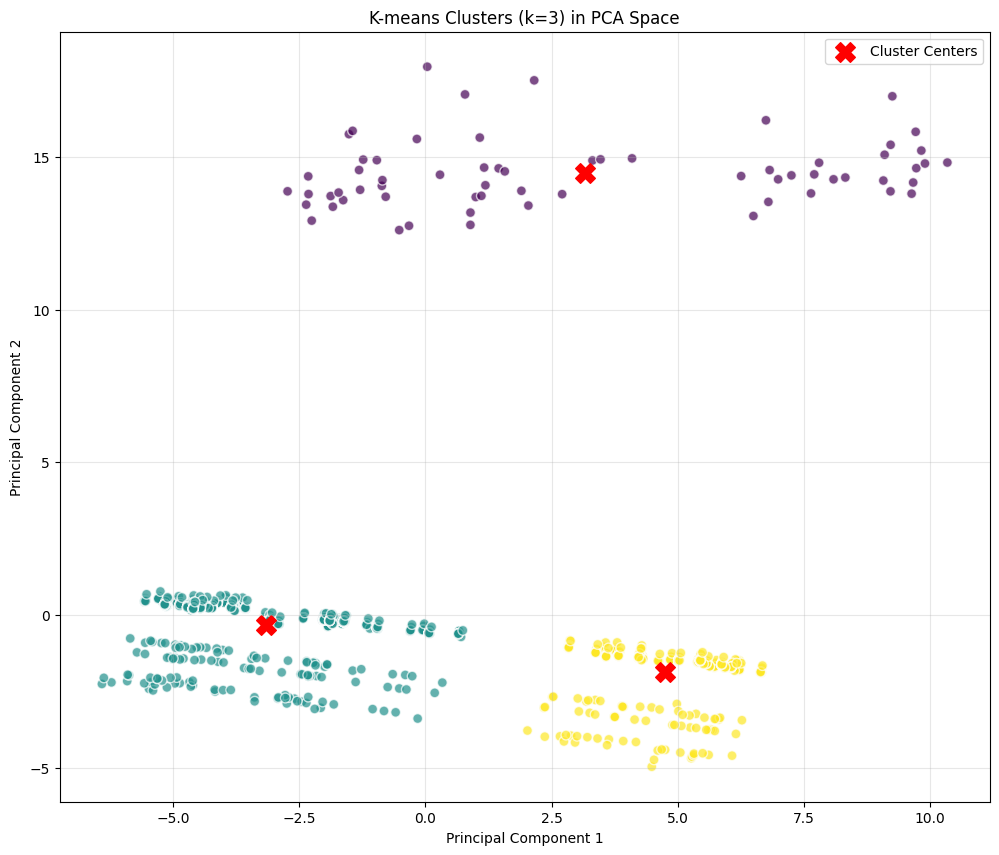

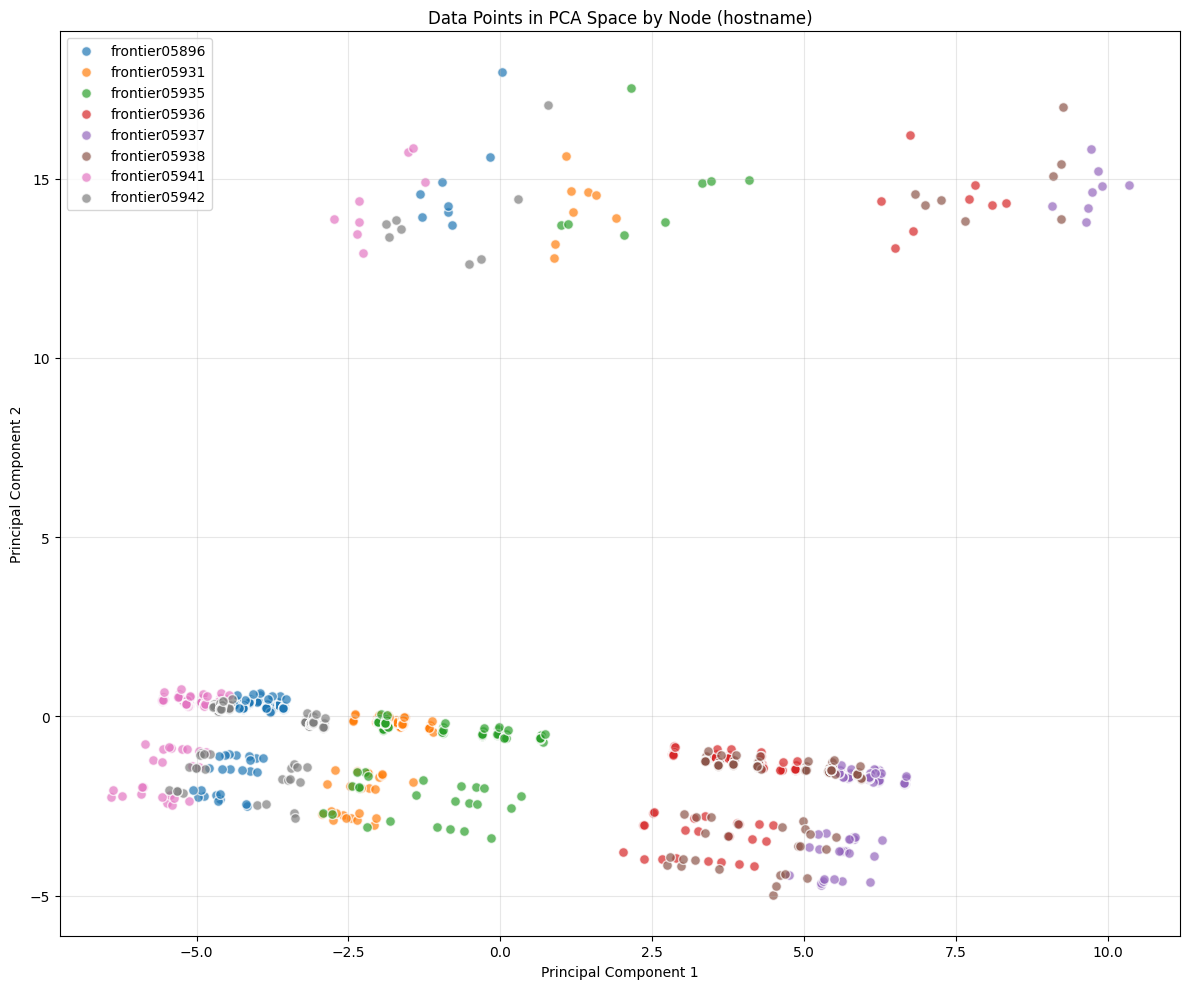


PCA Explained Variance Ratio: [0.273  0.2222]
Total Explained Variance: 0.4952


In [210]:
k = 3

tids = pivot_df['index'].values

feature_cols = X.columns

X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=random_state)

cluster_labels = kmeans.fit_predict(X_scaled)

# # Add cluster labels to the data
# data_with_clusters = X.copy()
# data_with_clusters['cluster'] = cluster_labels

# Get the top features for each cluster
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=feature_cols
)

# Transform the cluster centers back to the original scale
cluster_centers_orig = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=feature_cols
)

# Calculate feature importance for each cluster
feature_variance = cluster_centers.var().sort_values(ascending=False)

# Normalize to get relative importance
feature_importance = feature_variance / feature_variance.sum()

# Use PCA for dimensionality reduction to get better visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pc_df = pd.DataFrame(
    data=principal_components, 
    columns=['PC1', 'PC2']
)

print(f"\nPCA Explained Variance Ratio: {pca.explained_variance_ratio_.round(4)}")
print(f"Total Explained Variance: {sum(pca.explained_variance_ratio_).round(4)}")

# See which features contribute most to the principal components
pca_components = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_cols
)

print("\nTop 5 features contributing to PC1:")
print(pca_components['PC1'].abs().sort_values(ascending=False).head(5))

print("\nTop 5 features contributing to PC2:")
print(pca_components['PC2'].abs().sort_values(ascending=False).head(5))

# Combine with original data for plotting
pc_df['cluster'] = cluster_labels

# Plot clusters in PCA space
plt.figure(figsize=(12, 10))

# Plot clusters
scatter = plt.scatter(
    pc_df['PC1'], 
    pc_df['PC2'], 
    c=pc_df['cluster'], 
    cmap='viridis', 
    alpha=0.7, 
    s=50, 
    edgecolors='w'
)

# Plot cluster centers in PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centers_pca[:, 0], 
    centers_pca[:, 1], 
    c='red', 
    marker='X', 
    s=200, 
    alpha=1, 
    label='Cluster Centers'
)

plt.title(f'K-means Clusters (k={k}) in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

hostnames = pivot_df['hostname'].values

# PCA w 2 Components
principal_components = pca.fit_transform(X_scaled)
pc_df = pd.DataFrame(
    data=principal_components,
    columns=['PC1', 'PC2']
)

# Add hostname and tid information to the PC dataframe instead of cluster labels
pc_df['hostname'] = hostnames
pc_df['tid'] = tids

# Get unique hostnames for coloring
unique_hostnames = pc_df['hostname'].unique()

# Create a color map for the hostnames
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

# Distinct color list
tab10 = plt.colormaps['tab10']
tab20 = plt.colormaps['tab20']
tab20b = plt.colormaps['tab20b']
tab20c = plt.colormaps['tab20c']

colors = [tab10(i % 10) for i in range(10)]
colors.extend([tab20(i % 20) for i in range(20)])
colors.extend([tab20b(i % 20) for i in range(20)])
colors.extend([tab20c(i % 20) for i in range(20)])

# Assign a color to each hostname
hostname_colors = {hostname: colors[i % len(colors)] for i, hostname in enumerate(unique_hostnames)}

# Plot the PCA with hostname coloring
plt.figure(figsize=(12, 10))

# Plot points colored by hostname
for hostname in unique_hostnames:
    subset = pc_df[pc_df['hostname'] == hostname]
    plt.scatter(
        subset['PC1'],
        subset['PC2'],
        color=hostname_colors[hostname],
        alpha=0.7,
        s=50,
        edgecolors='w',
        label=hostname
    )

plt.title('Data Points in PCA Space by Node (hostname)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Create custom legend if there are many hostnames
if len(unique_hostnames) > 10:
    # Create a more compact legend for many hostnames
    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=hostname_colors[h], markersize=8, label=h)
                      for h in unique_hostnames]
    plt.legend(handles=legend_elements, loc='best', ncol=2, fontsize='small')
else:
    plt.legend(loc='best')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# PCA Display for hostname
print(f"\nPCA Explained Variance Ratio: {pca.explained_variance_ratio_.round(4)}")
print(f"Total Explained Variance: {sum(pca.explained_variance_ratio_).round(4)}")

The first component appears to capture workloads by memory consumption patterns and volatility. The second captures processor workload characteristics. 

We see three clusters.
The bottom left are clusters with low PC2 values and negative PC1 values. These may be describing processes with higher idle or user time. I would suspect idle time since most of the computations are likely being done on GPUs.
The bottom right are clusters with low PC2 values and high PC1 values. These processes are using a lot of memory, but are also low in actual activity overall. In other words, they are memory intensive but not switching contexts frequently. This cluster may be describing processes that are handling GPU memory without directly handling computation. 
The top cluster have high PC2 values. Some low PC1 values and some have high PC1 values. We are seeing high system level interactions, high context switching, and varying memory consumption. These may be processes that are handling parallelism, experiencing resource contention, or frequently interacting with the system. 

# Results and Analysis

## Key Findings

The analysis of performance data collected through Zerosum yielded several important insights:

- Raw performance data alone provides limited visibility into application behavior
- Visualization and derived metrics significantly improve application characterization
- A multiple logistic regression model demonstrated high accuracy in workload classification
- Resource utilization patterns can be effectively categorized even with limited training data

## Evidence Supporting Conclusions

The impressive performance of the multiple logistic regression model leads me to believe that given a bigger labeled dataset, we could accurately classify application bounds for a variety of different tasks and faults.

- Visualization techniques revealed distinct patterns in resource utilization that were not apparent in raw metrics
- Calculated features (means, standard deviations, deltas) provided discriminative power in the absense of using raw time-series data
- Classification models successfully differentiated between:
  * CPU-bound processes
  * Memory-bound operations
  * I/O-bound processes
  * Deadlocked scenarios
  * Unbalanced workloads

## Practical Applications

This analysis opens several promising avenues for practical application:

1. **User-Friendly Resource Analysis**: The ability to provide descriptive analysis to users who are not familiar with resource metrics
2. **Resource Scheduling Optimization**: Potential for making evidence-based suggestions for batched job scheduling
3. **Automated Performance Troubleshooting**: Identification of resource contention and deadlocks without manual inspection

## Limitations and Challenges {#sec-limitations}

Several factors limit the generalizability of the current analysis:

| Limitation | Description | Impact |
|------------|-------------|--------|
| Dataset Size | Small number of samples | Potential overfitting, limited variety of workload patterns |
| Workload Diversity | Limited variety of tasks | May not capture full spectrum of real-world applications |
| Memory Metrics | Shared memory property for each hardware thread | Likely inflated model accuracy due to only 10 samples |
| Time Constraints | Focus on analysis over dataset generation | Prevented creation of large, diverse, balanced dataset |

## Future Work

To address the current limitations and extend this proect, I would propose:

### Additional Data Collection

- Run diverse benchmark applications with Zerosum
  * Benchmarks are widely accepted and already labeled
  * Would provide standardized comparison points

### Expanded Execution Environment

- Deploy test workloads on a cluster environment
- Generate models based on both HWT and LWP observations
- Test across heterogeneous hardware configurations

### Advanced Analytical Approaches

- Implement time series analysis to identify trends and predict utilization
- Explore unsupervised learning approaches for anomaly detection
- Develop transfer learning techniques to adapt models across different systems

### End-User Tool Development

- Create intuitive visualizations for non-expert users
- Develop automated recommendation systems for resource allocation
- Integrate with existing job scheduling systems (like Argobots or IRIS)

### Impact

The impact my methodologies would have is better in situ application utilization visibility for those interested in performance using heterogeneous devices. While zerosum is doing the the difficult work of tapping into sources, consolidating the data, analyzing configurability issues, and producing results, the visualization of these results is limited. With further exploration, I would hope that my results can produce a more user friendly utilization analysis. 
If my analysis is incorrect, my models could cause more confusion about resource utilization and likely discourage users from using resource monitoring. 